# IL-17 signal in public data

# Loading data

## Libraries and functions

In [2]:
pacman::p_load(
  data.table,
  readr,
  gsheet,
  janitor,
  dplyr,
  ggplot2,
  ggrepel,
  ggbeeswarm,
  patchwork,
  magrittr,
  ggstance,
  fractional,
  RColorBrewer,
  stringr,
  limma,
  pheatmap,
  seriation,
  scico
)

In [3]:
theme_set(theme_classic(base_size = 18) %+replace% theme(
  strip.background = element_blank(),
  # axis.line.y = element_line(colour = "black", size = 0.2),
  # axis.line.x = element_line(colour = "black", size = 0.2),
  axis.ticks   = element_line(colour = "black", size = 0.3),
  panel.border = element_rect(size = 0.3, fill = NA),
  axis.line    = element_blank(),
  plot.title   = element_text(size = 18, vjust = 2, hjust = 0.5),
  panel.grid.major = element_line(size = 0.2)
))

In [4]:
scale_fill_scico_auto <- function(xs, ...) {
  offset <- abs(diff(abs(range(xs)))) / max(abs(xs)) / 2
  if (abs(min(xs)) > abs(max(xs))) {
    begin <- 0
    end   <- 1 - offset
  } else {
    begin <- offset
    end   <- 1 
  }
  return(scico::scale_fill_scico(begin = begin, end = end, ...))
}

In [5]:
extreme_n <- function(xs, n = 10) {
  xs_rank <- rank(xs)
  i_low <- ceiling(n / 2)
  i_high <- length(xs) - floor(n / 2)
  c(which(xs_rank <= i_low), which(xs_rank > i_high))
}

In [6]:
pow_trans <- function(power = 2) {
  force(power)
  trans <- function(x) x ^ power
  inv <- function(x) x ^ (1 / power)
  scales::trans_new(paste0("power-", format(power)), trans, inv)
}

In [7]:
winsorize <- function(x, limit = 3) {
  x[x > limit] <- limit
  x[x < -limit] <- -limit
  x
}

In [8]:
setwd("~/work/fibroblast_timecourse")
source("R/002_helper_functions.R")

In [9]:
qpcr_colors = list(
  cell_line = c(
    'RA1357'   = '#1B9E77',
    'RA160425' = '#E6AB02',
    'RA355'    = '#7570B3',
    'RA3916'   = '#E7298A'
  ),
  stimulation = c(
    "None" = "grey50",
    "TNF (0.1ng/mL)" = "#FEB24C",
    "TNF (0.1ng/mL)+IL-17 (1ng/mL)" = "#E31A1C"
  )
)

In [10]:
# The palette with grey:
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

# The palette with black:
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

meta_colors <- list(
  "tissue_type" = c(
    "OA-arthro"  = "#6A3D9A",
    "RA-arthro"  = "#FFD8B2",
    "RA-biopsy"  = "#FF7F00"
  ),
  "status" = c(
    "OA"                = "#6A3D9A",
    "leukocyte-poor RA" = "#FFD8B2",
    "leukocyte-rich RA" = "#FF7F00"
  ),
  "diseasen" = c(
    "Arthralgia (n=10)" = "#33A02C",
    "Normal (n=28)" = "#1F78B4",
    "Osteoarthritis (n=22)" = "#6A3D9A",
    "Rheumatoid arthritis (established) (n=95)" = "#FFD8B2",
    "Rheumatoid arthritis (early) (n=57)" = "#FF7F00",
    "Undifferentiated arthritis (n=6)" = "#E31A1C"
  )
)

 [1] "#A6CEE3" "#1F78B4" "#B2DF8A" "#33A02C" "#FB9A99" "#E31A1C" "#FDBF6F"
 [8] "#FF7F00" "#CAB2D6" "#6A3D9A" "#FFFF99"


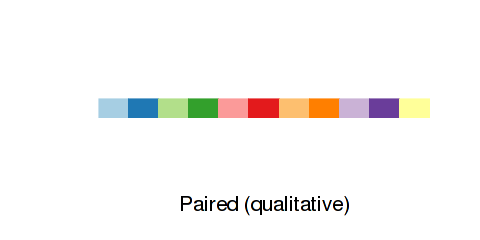

In [11]:
options(repr.plot.width = 4, repr.plot.height = 2)
display.brewer.pal(n = 11, "Paired")
print(brewer.pal(11, "Paired"))

## Ensembl 75 and 83

In [12]:
ens75 <- read_tsv("/data/srlab/public/srcollab/AMP/rnaseq/processed/Phase1/lowinput/kamil/Homo_sapiens.GRCh37.75.tsv.gz")
ens75_to_symbol <- unlist(with(
  (
    ens75 %>%
    select(gene_id, gene_name) %>%
    unique()
  ),
  split(gene_name, gene_id)
))
print(ens75_to_symbol[1:5])

Parsed with column specification:
cols(
  transcript_id = col_character(),
  gene_id = col_character(),
  gene_name = col_character()
)


ENSG00000000003 ENSG00000000005 ENSG00000000419 ENSG00000000457 ENSG00000000460 
       "TSPAN6"          "TNMD"          "DPM1"         "SCYL3"      "C1orf112" 


In [13]:
symbol_to_ens75 <- unlist(with(
  (
    ens75 %>%
    select(gene_id, gene_name) %>%
    unique()
  ),
  split(gene_id, gene_name)
))
print(symbol_to_ens75[1:5])

         5S_rRNA1          5S_rRNA2          5S_rRNA3          5S_rRNA4 
"ENSG00000271924" "ENSG00000272351" "ENSG00000201285" "ENSG00000212595" 
         5S_rRNA5 
"ENSG00000272435" 


In [14]:
ens83 <- read_tsv("/data/srlab/public/srcollab/AMP/rnaseq/processed/Phase1/lowinput/kamil/Homo_sapiens.GRCh38.cdna.lincrna.filtered.genes.tsv.gz")
ens83_to_symbol <- unlist(with(
  (
    ens83 %>%
    select(gene_id, hgnc_symbol) %>%
    unique()
  ),
  split(hgnc_symbol, gene_id)
))
print(ens83_to_symbol[1:5])

Parsed with column specification:
cols(
  gene_id = col_character(),
  transcript_id = col_character(),
  hgnc_symbol = col_character()
)


ENSG00000000003 ENSG00000000005 ENSG00000000419 ENSG00000000457 ENSG00000000460 
       "TSPAN6"          "TNMD"          "DPM1"         "SCYL3"      "C1orf112" 


## IL-17 dose-response data

In [15]:
d_dose <- read_tsv(
  file = "analysis/limma/002_dose_limma_timefactor_dosefactor.tsv.gz",
  col_types = cols(
    ID = col_character(),
    logFC = col_double(),
    CI.L = col_double(),
    CI.R = col_double(),
    AveExpr = col_double(),
    t = col_double(),
    P.Value = col_double(),
    adj.P.Val = col_double(),
    B = col_double(),
    ensembl_id = col_character(),
    Coef = col_character()
  )
)

d_dose %>% head()

ID     logFC   CI.L    CI.R    AveExpr t        P.Value    adj.P.Val 
1 GAPDH  12.2361 12.1392 12.3330 11.9755 249.3115 1.073e-216 2.133e-212
2 TPT1   12.2502 12.1431 12.3573 12.1497 225.8334 1.524e-209 1.515e-205
3 UBB    10.3344 10.2414 10.4273 10.4976 219.5213 1.707e-207 1.131e-203
4 SRP14   9.1075  9.0214  9.1936  9.0615 208.7697 7.266e-204 3.611e-200
5 COX4I1  9.6292  9.5299  9.7285  9.6275 191.4095 1.355e-197 5.386e-194
6 PPIB    9.9307  9.8237 10.0376  9.8865 183.3484 1.729e-194 5.729e-191
  B        ensembl_id      Coef      signif
1 449.8856 ENSG00000111640 Intercept TRUE  
2 439.2062 ENSG00000133112 Intercept TRUE  
3 436.0108 ENSG00000170315 Intercept TRUE  
4 430.2092 ENSG00000140319 Intercept TRUE  
5 419.7734 ENSG00000131143 Intercept TRUE  
6 414.4209 ENSG00000166794 Intercept TRUE

## siRNA data

In [32]:
d_sirna <- read_tsv(
  file = "analysis/limma/003_sirna_limma_dosetime_sirna.tsv.gz",
  col_types = cols(
    ID = col_character(),
    logFC = col_double(),
    CI.L = col_double(),
    CI.R = col_double(),
    AveExpr = col_double(),
    t = col_double(),
    P.Value = col_double(),
    adj.P.Val = col_double(),
    B = col_double(),
    ensembl_id = col_character(),
    Coef = col_character()
  )
)

d_sirna %>% head()

ID       logFC   CI.L    CI.R    AveExpr t        P.Value    adj.P.Val 
1 HSP90AA1  8.9697  8.8618  9.0776  8.7117 164.0223 4.199e-199 1.213e-194
2 ATP6V0E1  9.2405  9.1260  9.3549  9.1111 159.2446 8.619e-197 1.245e-192
3 B2M      12.3925 12.2313 12.5537 12.7759 151.7068 5.327e-193 5.129e-189
4 FTH1     14.0000 13.8101 14.1899 14.2173 145.4519 1.037e-189 7.489e-186
5 VIM      12.3583 12.1832 12.5333 12.3606 139.3005 2.450e-186 1.416e-182
6 PCOLCE    9.6990  9.5581  9.8399  9.3786 135.8349 2.263e-184 1.090e-180
  B        ensembl_id      Coef      FC        FC.R      FC.L     
1 443.7367 ENSG00000080824 Intercept 1.995e-03 2.149e-03 1.851e-03
2 438.6129 ENSG00000113732 Intercept 1.653e-03 1.790e-03 1.527e-03
3 430.1858 ENSG00000166710 Intercept 1.860e-04 2.080e-04 1.663e-04
4 422.8487 ENSG00000167996 Intercept 6.103e-05 6.962e-05 5.351e-05
5 415.3016 ENSG00000026025 Intercept 1.905e-04 2.150e-04 1.687e-04
6 410.8946 ENSG00000106333 Intercept 1.203e-03 1.327e-03 1.091e-03

## AMP Phase 1 RA Smart-seq2 bulk RNA-seq data

In [33]:
x <- readxl::read_excel("/data/srlab/public/srcollab/AMP/amp_phase1_ra/data/postQC_all_samples.xlsx")
table(x$Disease, x$Mahalanobis > 20)

patient_maha <- x$Mahalanobis
names(patient_maha) <- x$Patient

    
     FALSE TRUE
  OA    15    0
  RA    17   19

In [34]:
#bulk <- readRDS("/data/srlab/public/srcollab/AMP/amp_phase1_ra/data/filtered_log2tpm_lowinput_phase_1.rds")
bulk_meta <- readRDS("/data/srlab/public/srcollab/AMP/amp_phase1_ra/data/filtered_meta_lowinput_phase_1.rds")
bulk_meta <- janitor::clean_names(bulk_meta)
rownames(bulk_meta) <- bulk_meta$sample_id

bulk_meta$maha <- patient_maha[bulk_meta$donor_id]
bulk_meta$status <- substr(bulk_meta$tissue_type, 1, 2)
bulk_meta$status[bulk_meta$maha > 20 & bulk_meta$status == "RA"] <- "leukocyte-rich RA"
bulk_meta$status[bulk_meta$maha < 20 & bulk_meta$status == "RA"] <- "leukocyte-poor RA"
table(bulk_meta$status)

bulk_meta[1:5,1:5]


leukocyte-poor RA leukocyte-rich RA                OA 
               55                67                45 

donor_id sample_id sample_date cell_type tissue_type
S232 300-0512 S232      5/6/16      Monocyte  RA-biopsy  
S10  301-0156 S10       9/14/16     Monocyte  RA-arthro  
S18  301-0158 S18       9/14/16     Monocyte  RA-arthro  
S26  301-0151 S26       9/15/16     Monocyte  RA-arthro  
S34  301-0153 S34       9/15/16     Monocyte  RA-arthro

In [35]:
bulk <- readRDS("/data/srlab/public/srcollab/AMP/rnaseq/processed/Phase1/lowinput/kamil/lowinput_ensembl83_txi.rds")
bulk <- log2(bulk$abundance + 1)
bulk <- bulk[,bulk_meta$sample_id]
bulk <- bulk[rowSums(bulk) > 0, ]

In [36]:
dim(bulk)
bulk[1:5,1:5]

[1] 41602   167

S232      S10       S18       S26       S34      
ENSG00000000003 0.1334859 0.1181510 0.2224035 0.9138902 0.5654402
ENSG00000000005 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
ENSG00000000419 5.4113865 5.0351547 6.0105833 6.0797745 5.5785133
ENSG00000000457 2.2274577 1.7645821 1.6574761 1.6507792 1.2541620
ENSG00000000460 1.8677139 0.7403908 2.4656484 2.3078555 2.9258348

In [37]:
sum(unique(d_dose$ensembl_id) %in% names(ens83_to_symbol)) / length(unique(d_dose$ensembl_id))
sum(unique(d_dose$ensembl_id) %in% names(ens75_to_symbol)) / length(unique(d_dose$ensembl_id))

[1] 0.9943156

[1] 0.9780673

In [38]:
sum(unique(d_sirna$ensembl_id) %in% names(ens83_to_symbol)) / length(unique(d_sirna$ensembl_id))
sum(unique(d_sirna$ensembl_id) %in% names(ens75_to_symbol)) / length(unique(d_sirna$ensembl_id))

[1] 0.9925575

[1] 0.9688106

The bulk RNA-seq data was run with Ensembl 83.

The single-cell RNA-seq data was run with Ensembl 75.

In [39]:
sum(rownames(bulk) %in% names(ens83_to_symbol)) / nrow(bulk)
sum(rownames(bulk) %in% names(ens75_to_symbol)) / nrow(bulk)

[1] 0.9999279

[1] 0.951685

How many genes are measured in both datasets?

In [40]:
bulk_ens83 <- rownames(bulk)
dose_ens83 <- unique(d_dose$ensembl_id)
sirna_ens83 <- unique(d_sirna$ensembl_id)

both_bulk_dose <- intersect(bulk_ens83, dose_ens83)
both_bulk_sirna <- intersect(bulk_ens83, sirna_ens83)

length(bulk_ens83)
length(dose_ens83)
length(sirna_ens83)

length(both_bulk_dose)
length(both_bulk_sirna)

[1] 41602

[1] 19879

[1] 28888

[1] 19745

[1] 28600

Let's just check to see what we're missing.

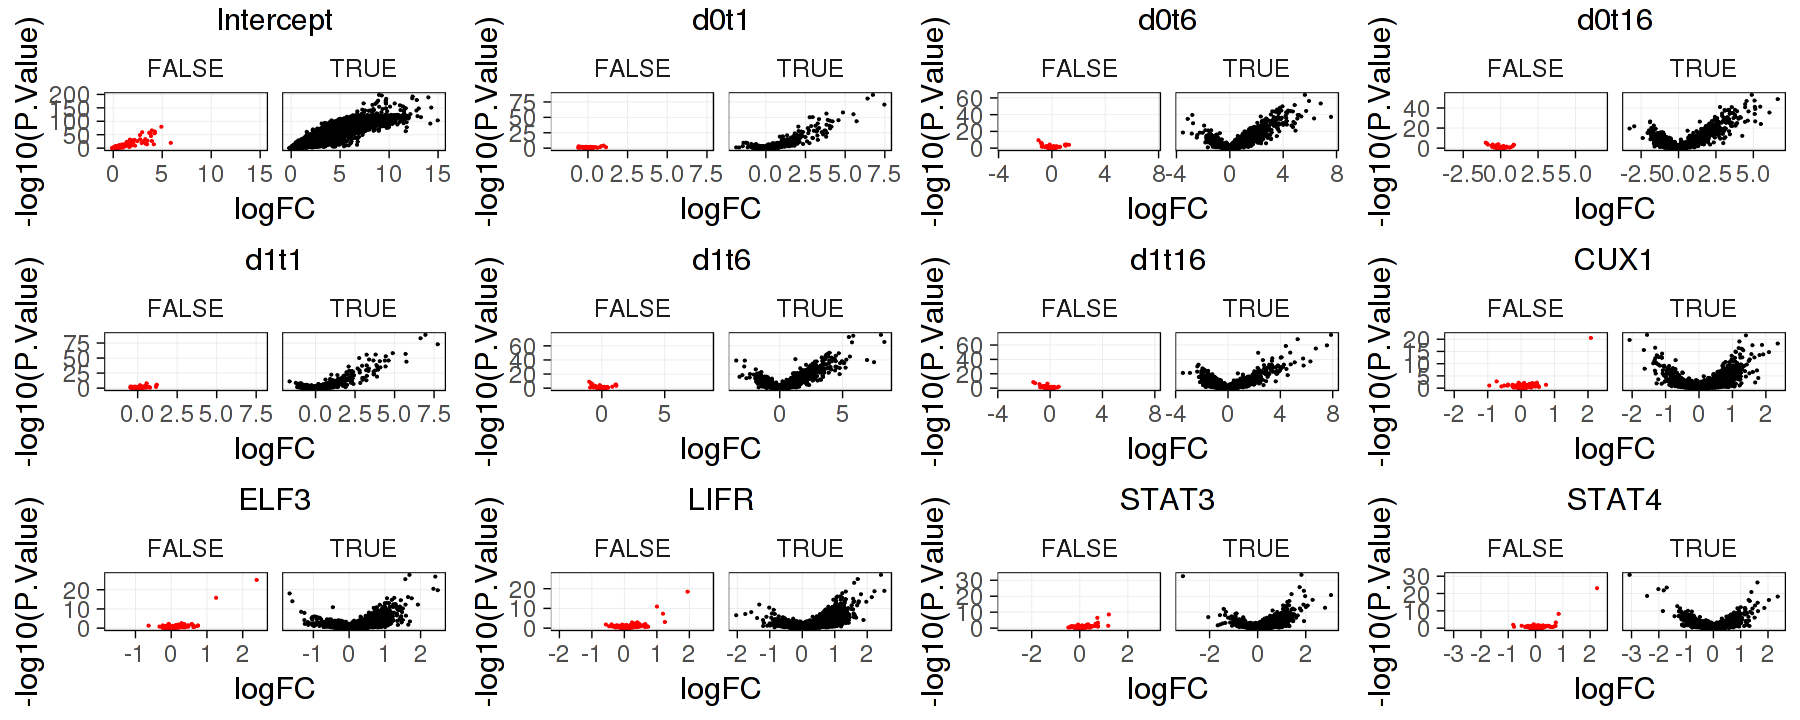

In [41]:
options(repr.plot.width = 15, repr.plot.height = 6)

plots <- lapply(unique(d_sirna$Coef), function(this_coef) {
  d_sirna %>%
  mutate(in_bulk = ensembl_id %in% both_bulk_sirna) %>%
  filter(Coef == this_coef) %>%
  filter(ID != "PRG4") %>%
  ggplot() +
  aes(x = logFC, y = -log10(P.Value), color = in_bulk) +
  geom_point(size = 0.1) +
  facet_wrap(~ in_bulk) +
  scale_color_manual(values = c("red", "black"), guide = FALSE) +
  labs(title = this_coef)
})

wrap_plots(plots)

Looks like the bulk RNA-seq data does not have lincRNAs.

In [42]:
d_sirna %>%
mutate(in_bulk = ensembl_id %in% both_bulk_sirna) %>%
filter(!in_bulk) %>%
filter(ID != "PRG4") %>%
filter(abs(logFC) > 1)

ID          logFC   CI.L    CI.R    AveExpr t       P.Value   adj.P.Val
1  LINC00094   4.9068  4.6208  5.1927  4.8244  33.8564 2.566e-80 2.624e-79
2  AC007326.4  3.9355  3.6533  4.2177  4.1748  27.5196 1.190e-66 7.688e-66
3  UMAD1       4.2315  3.9085  4.5545  4.0525  25.8502 1.019e-62 5.863e-62
4  AC015802.6  2.9477  2.7120  3.1834  3.5691  24.6732 7.418e-60 3.968e-59
5  PSMD5-AS1   3.6698  3.3658  3.9739  3.4162  23.8174 9.962e-58 5.050e-57
6  TSTD3       4.2149  3.8550  4.5747  4.1535  23.1092 6.161e-56 2.979e-55
7  CU639417.1  3.7893  3.4591  4.1195  5.4241  22.6416 9.722e-55 4.575e-54
8  C2orf81     2.7202  2.4602  2.9803  2.2024  20.6392 1.785e-49 7.514e-49
9  SMIM27      3.8548  3.4599  4.2497  3.1458  19.2617 9.927e-46 3.898e-45
10 AC241585.2  3.2690  2.8450  3.6931  3.8065  15.2107 3.256e-34 1.060e-33
11 PCOTH       2.7355  2.3767  3.0943  2.6869  15.0430 1.004e-33 3.241e-33
12 ZNRD1ASP    1.6930  1.4620  1.9240  1.6007  14.4626 5.006e-32 1.577e-31
13 TP73-AS1    1.7079  1.4744  1.9414  2.0248  14.4310 6.196e-32 1.949e-31
14 AC069544.2  2.1624  1.8637  2.4611  2.2533  14.2827 1.687e-31 5.276e-31
15 INAFM2      1.8625  1.5967  2.1282  1.4080  13.8278 3.653e-30 1.122e-29
16 LINC02210   3.4790  2.9594  3.9985  3.3887  13.2116 2.366e-28 7.099e-28
17 LINC01125   3.9270  3.3244  4.5296  3.9898  12.8578 2.594e-27 7.668e-27
18 AC002472.2  1.7166  1.4513  1.9820  1.4544  12.7627 4.936e-27 1.455e-26
19 SRP54-AS1   2.4477  2.0652  2.8303  2.4432  12.6250 1.253e-26 3.674e-26
20 SPACA6      3.0570  2.5792  3.5349  3.1385  12.6237 1.264e-26 3.706e-26
21 AC104581.1  1.3770  1.1463  1.6077  1.4027  11.7772 3.807e-24 1.083e-23
22 AC092718.3  1.7956  1.4708  2.1204  1.8687  10.9093 1.259e-21 3.470e-21
23 AC068547.1  2.0377  1.6583  2.4171  1.8240  10.5981 9.884e-21 2.694e-20
24 AC244452.4  5.8646  4.7595  6.9696  5.9297  10.4718 2.272e-20 6.160e-20
25 AC233280.20 2.8966  2.3388  3.4544  2.7506  10.2467 9.964e-20 2.681e-19
26 AC008013.1  3.2753  2.6040  3.9467  3.5768   9.6262 5.610e-18 1.479e-17
27 BTBD8       1.1818  0.9204  1.4432  1.0233   8.9206 4.986e-16 1.282e-15
28 AL022238.4  1.4085  1.0878  1.7292  1.3336   8.6660 2.444e-15 6.225e-15
29 ANKRD36BP1  3.4396  2.6446  4.2346  3.6234   8.5365 5.446e-15 1.380e-14
30 AC137499.1  4.1342  3.1774  5.0910  3.9271   8.5256 5.823e-15 1.475e-14
⋮  ⋮           ⋮       ⋮       ⋮       ⋮       ⋮       ⋮         ⋮        
42 IQCJ-SCHIP1  1.1778  0.7984  1.5573 1.4549   6.1250 5.492e-09 1.249e-08
43 AL691432.1   1.2043  0.8041  1.6045 1.3575   5.9378 1.441e-08 3.240e-08
44 AC013268.1   1.0775  0.6934  1.4615 1.0577   5.5356 1.074e-07 2.349e-07
45 TMEM191A     1.0862  0.6919  1.4805 1.1749   5.4351 1.748e-07 3.795e-07
46 AP001160.5   1.0404  0.6252  1.4556 0.8824   4.9439 1.736e-06 3.629e-06
47 RPL12P16     1.6367  0.8494  2.4239 1.7602   4.1021 6.175e-05 1.196e-04
48 AC116533.1   1.1377  0.0551  2.2204 1.0632   2.0736 3.950e-02 6.071e-01
49 C2orf81     -1.0107 -1.3109 -0.7104 2.2024  -6.6409 3.509e-10 2.090e-08
50 AC241585.2   1.0579  0.5682  1.5475 3.8065   4.2627 3.243e-05 6.991e-04
51 SCO2         1.2731  0.6414  1.9049 2.3585   3.9763 1.010e-04 1.889e-03
52 SRP9P1       1.0240  0.4048  1.6432 0.4494   3.2631 1.317e-03 1.670e-02
53 AC099795.2   1.2083  0.7255  1.6911 0.6115   4.9383 1.781e-06 1.762e-04
54 SRP9P1       1.1603  0.5411  1.7795 0.4494   3.6973 2.885e-04 1.410e-02
55 AC009244.1   1.1658  0.2924  2.0393 1.0999   2.6338 9.174e-03 1.978e-01
56 AC002472.2  -1.0069 -1.3133 -0.7004 1.4544  -6.4827 8.267e-10 4.835e-08
57 AC241585.2   1.1296  0.6399  1.6192 3.8065   4.5517 9.729e-06 2.500e-04
58 AC118553.2   1.0734  0.5955  1.5514 2.1125   4.4314 1.617e-05 3.845e-04
59 SCO2         1.1482  0.5164  1.7799 2.3585   3.5860 4.316e-04 6.579e-03
60 AC019117.3  -1.2852 -1.6962 -0.8743 1.4382  -6.1711 4.319e-09 2.689e-07
61 PCOTH       -1.1563 -1.5706 -0.7420 2.6869  -5.5068 1.235e-07 5.391e-06
62 CU639417.1   2.0844  1.7031  2.4657 5.4241  10.7858 2.856e-21 2.063e-17
63 CU639417.1   2.3882  2.00

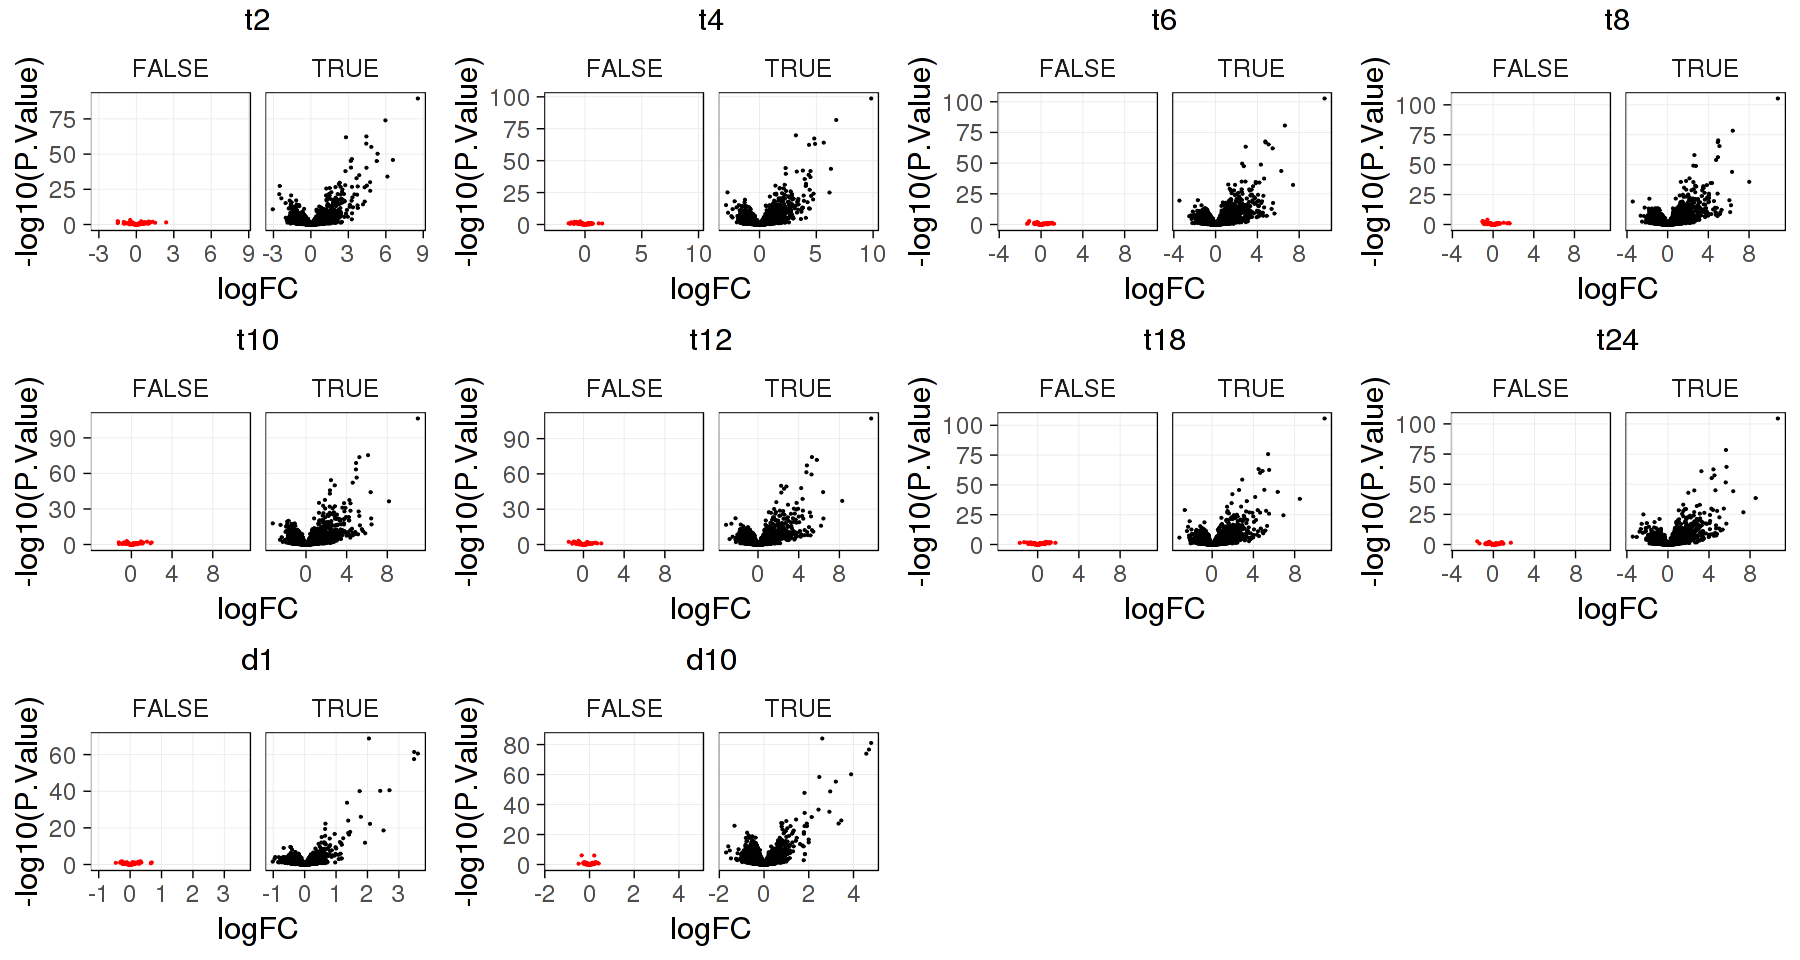

In [43]:
options(repr.plot.width = 15, repr.plot.height = 8)

plots <- lapply(setdiff(unique(d_dose$Coef), c("Intercept")), function(this_coef) {
  d_dose %>%
  mutate(in_bulk = ensembl_id %in% both_bulk_dose) %>%
  filter(Coef == this_coef) %>%
  ggplot() +
  aes(x = logFC, y = -log10(P.Value), color = in_bulk) +
  geom_point(size = 0.1) +
  facet_wrap(~ in_bulk) +
  scale_color_manual(values = c("red", "black"), guide = FALSE) +
  labs(title = this_coef)
})

wrap_plots(plots)

What are the missing genes with large effect sizes?

In [44]:
d_dose %>%
mutate(in_bulk = ensembl_id %in% both_bulk_dose) %>%
filter(!in_bulk) %>%
filter(Coef != "Intercept") %>%
filter(abs(logFC) > 1.5)

ID          logFC   CI.L      CI.R    AveExpr t       P.Value  adj.P.Val
1  PIGY         2.3862  0.222300  4.5501 2.4793   2.1771 0.030900 0.2219   
2  AC068631.2   1.5052 -0.041000  3.0514 2.0623   1.9219 0.056300 0.3099   
3  PIGY         1.5102 -0.653700  3.6741 2.4793   1.3778 0.170100 0.4970   
4  AC068631.2   1.5523  0.006124  3.0985 2.0623   1.9821 0.049100 0.2447   
5  PIGY         1.6130 -0.550900  3.7768 2.4793   1.4716 0.143000 0.4492   
6  AC233280.20  1.5283  0.498400  2.5583 1.9472   2.9296 0.003869 0.0375   
7  AC243994.1   1.9765  0.353000  3.6001 1.2183   2.4035 0.017300 0.1107   
8  PIGY         1.8762 -0.287600  4.0401 2.4793   1.7118 0.088800 0.3151   
9  PIGY         1.7461 -0.417800  3.9100 2.4793   1.5931 0.113000 0.3841   
10 AC243994.1   1.7208  0.097300  3.3444 1.2183   2.0926 0.037900 0.2040   
11 RPL12P16    -1.7396 -3.414700 -0.0645 2.6217  -2.0502 0.041900 0.2166   
12 AC069439.1  -1.5811 -2.592900 -0.5693 0.5437  -3.0852 0.002381 0.0326   
13 AC068631.2   1.6904  0.144100  3.2366 2.0623   2.1583 0.032300 0.2006   
   B       ensembl_id      Coef signif in_bulk
1  -4.5425 ENSG00000255072 t2   FALSE  FALSE  
2  -5.0501 ENSG00000283149 t2   FALSE  FALSE  
3  -5.9704 ENSG00000255072 t4   FALSE  FALSE  
4  -5.0041 ENSG00000283149 t8   FALSE  FALSE  
5  -5.8668 ENSG00000255072 t8   FALSE  FALSE  
6  -2.7817 ENSG00000283426 t10   TRUE  FALSE  
7  -4.1220 ENSG00000275129 t10  FALSE  FALSE  
8  -5.5046 ENSG00000255072 t10  FALSE  FALSE  
9  -5.6656 ENSG00000255072 t12  FALSE  FALSE  
10 -4.7305 ENSG00000275129 t18  FALSE  FALSE  
11 -4.8157 ENSG00000204196 t18  FALSE  FALSE  
12 -2.2879 ENSG00000239227 t24   TRUE  FALSE  
13 -4.6085 ENSG00000283149 t24  FALSE  FALSE

## AMP Bulk RNA-seq limma

In [45]:
clean_cols <- function(x) {
  colnames(x) <- str_replace_all(colnames(x), "[()]", "")
  colnames(x) <- str_replace_all(colnames(x), ":", "")
  colnames(x) <- str_replace_all(colnames(x), "status2", "")
  return(x)
}

ix <- which(bulk_meta$cell_type == "Fibroblast")
bulk_meta_fib <- bulk_meta[ix,]
bulk_fib <- bulk[,bulk_meta_fib$sample_id]
dim(bulk_fib)

bulk_meta_fib$status2 <- bulk_meta_fib$status
bulk_meta_fib$status2[bulk_meta_fib$status == "leukocyte-rich RA"] <- "RALR"
# bulk_meta_fib$status2[bulk_meta_fib$status == "leukocyte-poor RA"] <- "RALP"
bulk_meta_fib$status2[bulk_meta_fib$status == "leukocyte-poor RA"] <- "OA"

bulk_fib_des1 <- clean_cols(with(
  bulk_meta_fib,
  model.matrix(~ 0 + status2)
))
bulk_fib_fit1 <- lmFit(object = bulk_fib, design = bulk_fib_des1)
bulk_fib_fit1 <- eBayes(bulk_fib_fit1)

print(colnames(bulk_fib_des1))

bulk_fib_fit1_top <- rbindlist(lapply(unique(bulk_meta_fib$status2), function(this_coef) {
  retval <- topTable(bulk_fib_fit1, coef = this_coef, confint = TRUE, number = 1e6)
  retval$gene <- rownames(retval)
  retval$Coef <- this_coef
  retval
}))

bulk_fib_fit1_top %<>% mutate(
  FC   = 1 / 2^logFC,
  FC.R = 1 / 2^CI.L,
  FC.L = 1 / 2^CI.R
) 

bulk_fib_con1 <- limma::contrasts.fit(
  fit = bulk_fib_fit1,
  contrasts = makeContrasts(
    contrasts = c(
      "RALR - OA"
    ),
    levels = bulk_fib_des1
  )
)
bulk_fib_con1 <- eBayes(bulk_fib_con1)

bulk_fib_con1_top <- topTable(bulk_fib_con1, coef = 1, confint = TRUE, number = 1e6)
bulk_fib_con1_top <- cbind(ensembl_id = rownames(bulk_fib_con1_top), bulk_fib_con1_top, stringsAsFactors = FALSE)
bulk_fib_con1_top <- cbind(ID = ens83_to_symbol[rownames(bulk_fib_con1_top)], bulk_fib_con1_top, stringsAsFactors = FALSE)
rownames(bulk_fib_con1_top) <- seq(nrow(bulk_fib_con1_top))

head(bulk_fib_con1_top)

bulk_fib_con1_top %>% filter(ID %in% c("CUX1", "LIFR", "IL6"))


table(bulk_meta_fib$status)

[1] 41602    45

Warning message:
“Zero sample variances detected, have been offset away from zero”

[1] "OA"   "RALR"


Warning message:
“Zero sample variances detected, have been offset away from zero”

ID       ensembl_id      logFC    CI.L      CI.R     AveExpr   t       
1 GBP1     ENSG00000117228 2.668269 2.0651577 3.271380  4.968729 8.918211
2 HLA-DOA  ENSG00000204252 2.456692 1.8845969 3.028787  1.807764 8.656212
3 CD74     ENSG00000019582 3.346835 2.5563157 4.137354  8.189499 8.534291
4 HLA-DRA  ENSG00000204287 3.826594 2.9045938 4.748594  6.091036 8.366174
5 B2M      ENSG00000166710 1.218452 0.9193689 1.517534 13.573957 8.212254
6 HLA-DPB1 ENSG00000223865 2.258777 1.6862249 2.831330  5.637778 7.952500
  P.Value      adj.P.Val    B       
1 2.154886e-11 8.964755e-07 15.73337
2 5.000561e-11 1.028587e-06 14.93887
3 7.417339e-11 1.028587e-06 14.56627
4 1.280725e-10 1.332018e-06 14.04963
5 2.116961e-10 1.761396e-06 13.57378
6 4.968785e-10 2.882771e-06 12.76498

ID   ensembl_id      logFC      CI.L        CI.R       AveExpr  t        
1 CUX1 ENSG00000257923 -0.4552422 -0.66110779 -0.2493766 5.612325 -4.457631
2 IL6  ENSG00000136244  2.6211307  1.35142454  3.8908369 4.493126  4.161318
3 LIFR ENSG00000113594  0.2205607 -0.06820567  0.5093270 3.561990  1.539668
  P.Value      adj.P.Val   B        
1 5.709319e-05 0.005357181  1.683448
2 1.459048e-04 0.009746154  0.799407
3 1.308559e-01 0.542352169 -5.290090


leukocyte-poor RA leukocyte-rich RA                OA 
               17                16                12 

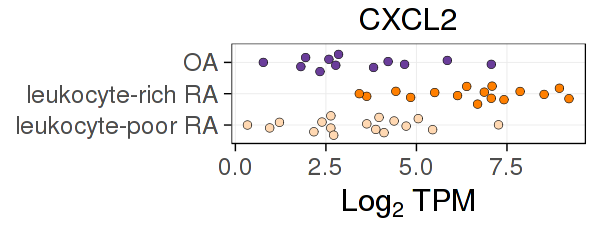

In [46]:
options(repr.plot.width = 5, repr.plot.height = 2)

this_gene <- "CXCL2"
this_ens <- names(ens83_to_symbol[which(ens83_to_symbol == this_gene)])
bulk_meta_fib$mygene <- as.numeric(bulk_fib[this_ens, ])

ggplot(bulk_meta_fib) +
aes(x = status, y = mygene, fill = status) +
geom_quasirandom(shape = 21, size = 2, stroke = 0.2) +
scale_fill_manual(values = meta_colors$status, name = NULL, guide = FALSE) +
coord_flip() +
labs(x = NULL, y = bquote("Log"[2]~"TPM"), title = ens83_to_symbol[[this_ens]])

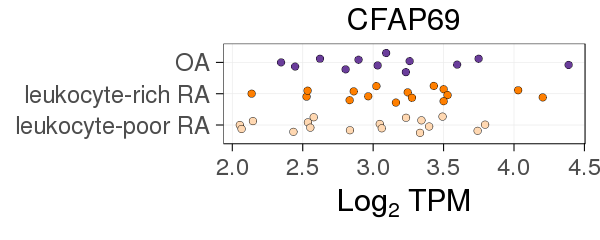

In [47]:
options(repr.plot.width = 5, repr.plot.height = 2)

this_gene <- "CFAP69"
this_ens <- names(ens83_to_symbol[which(ens83_to_symbol == this_gene)])
bulk_meta_fib$mygene <- as.numeric(bulk_fib[this_ens, ])

p <- ggplot(bulk_meta_fib) +
aes(x = status, y = mygene, fill = status) +
geom_quasirandom(shape = 21, size = 2, stroke = 0.2) +
scale_fill_manual(values = meta_colors$status, name = NULL, guide = FALSE) +
coord_flip() +
labs(x = NULL, y = bquote("Log"[2]~"TPM"), title = ens83_to_symbol[[this_ens]])

show_plot(p)

In [48]:
meta_colors$Status <- structure(
  c("#6A3D9A", "#FFD8B2", "#FF7F00"),
  .Names = c("OA", "Leukocyte-poor RA", "Leukocyte-rich RA"))

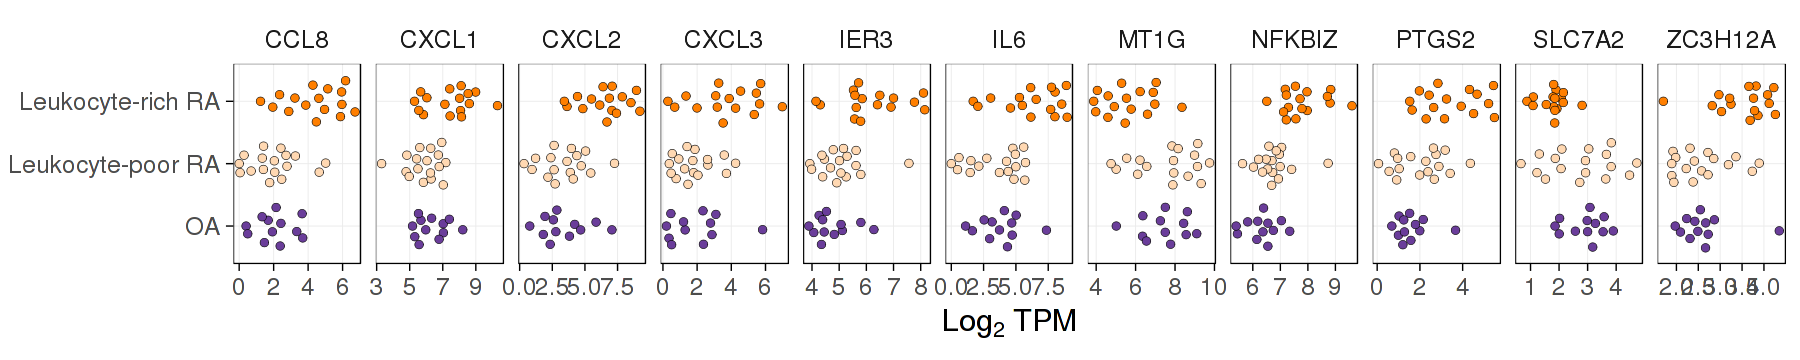

In [49]:
options(repr.plot.width = 15, repr.plot.height = 3)

this_gene <- c("CXCL2", "NFKBIZ", "CCL8", "ZC3H12A", "PTGS2", "MT1G", "IER3", "IL6", "SLC7A2", "CXCL1", "CXCL3")
this_ens <- names(ens83_to_symbol[which(ens83_to_symbol %in% this_gene)])

d <- cbind(
  bulk_meta_fib[,c("sample_id", "status")],
  {
    x <- t(bulk_fib[this_ens,])
    colnames(x) <- ens83_to_symbol[colnames(x)]
    x
  }
)

d <- d %>% tidyr::gather("gene", "value", -sample_id, -status)

d$status <- stringr::str_replace_all(as.character(d$status), "leu", "Leu")
d$status <- factor(as.character(d$status), c("OA", "Leukocyte-poor RA", "Leukocyte-rich RA"))

ggplot(d) +
aes(x = status, y = value, fill = status) +
facet_grid(~ gene, scales = "free_x") +
geom_quasirandom(shape = 21, size = 2, stroke = 0.2) +
scale_fill_manual(values = meta_colors$Status, name = NULL, guide = FALSE) +
coord_flip() +
labs(x = NULL, y = bquote("Log"[2]~"TPM"))

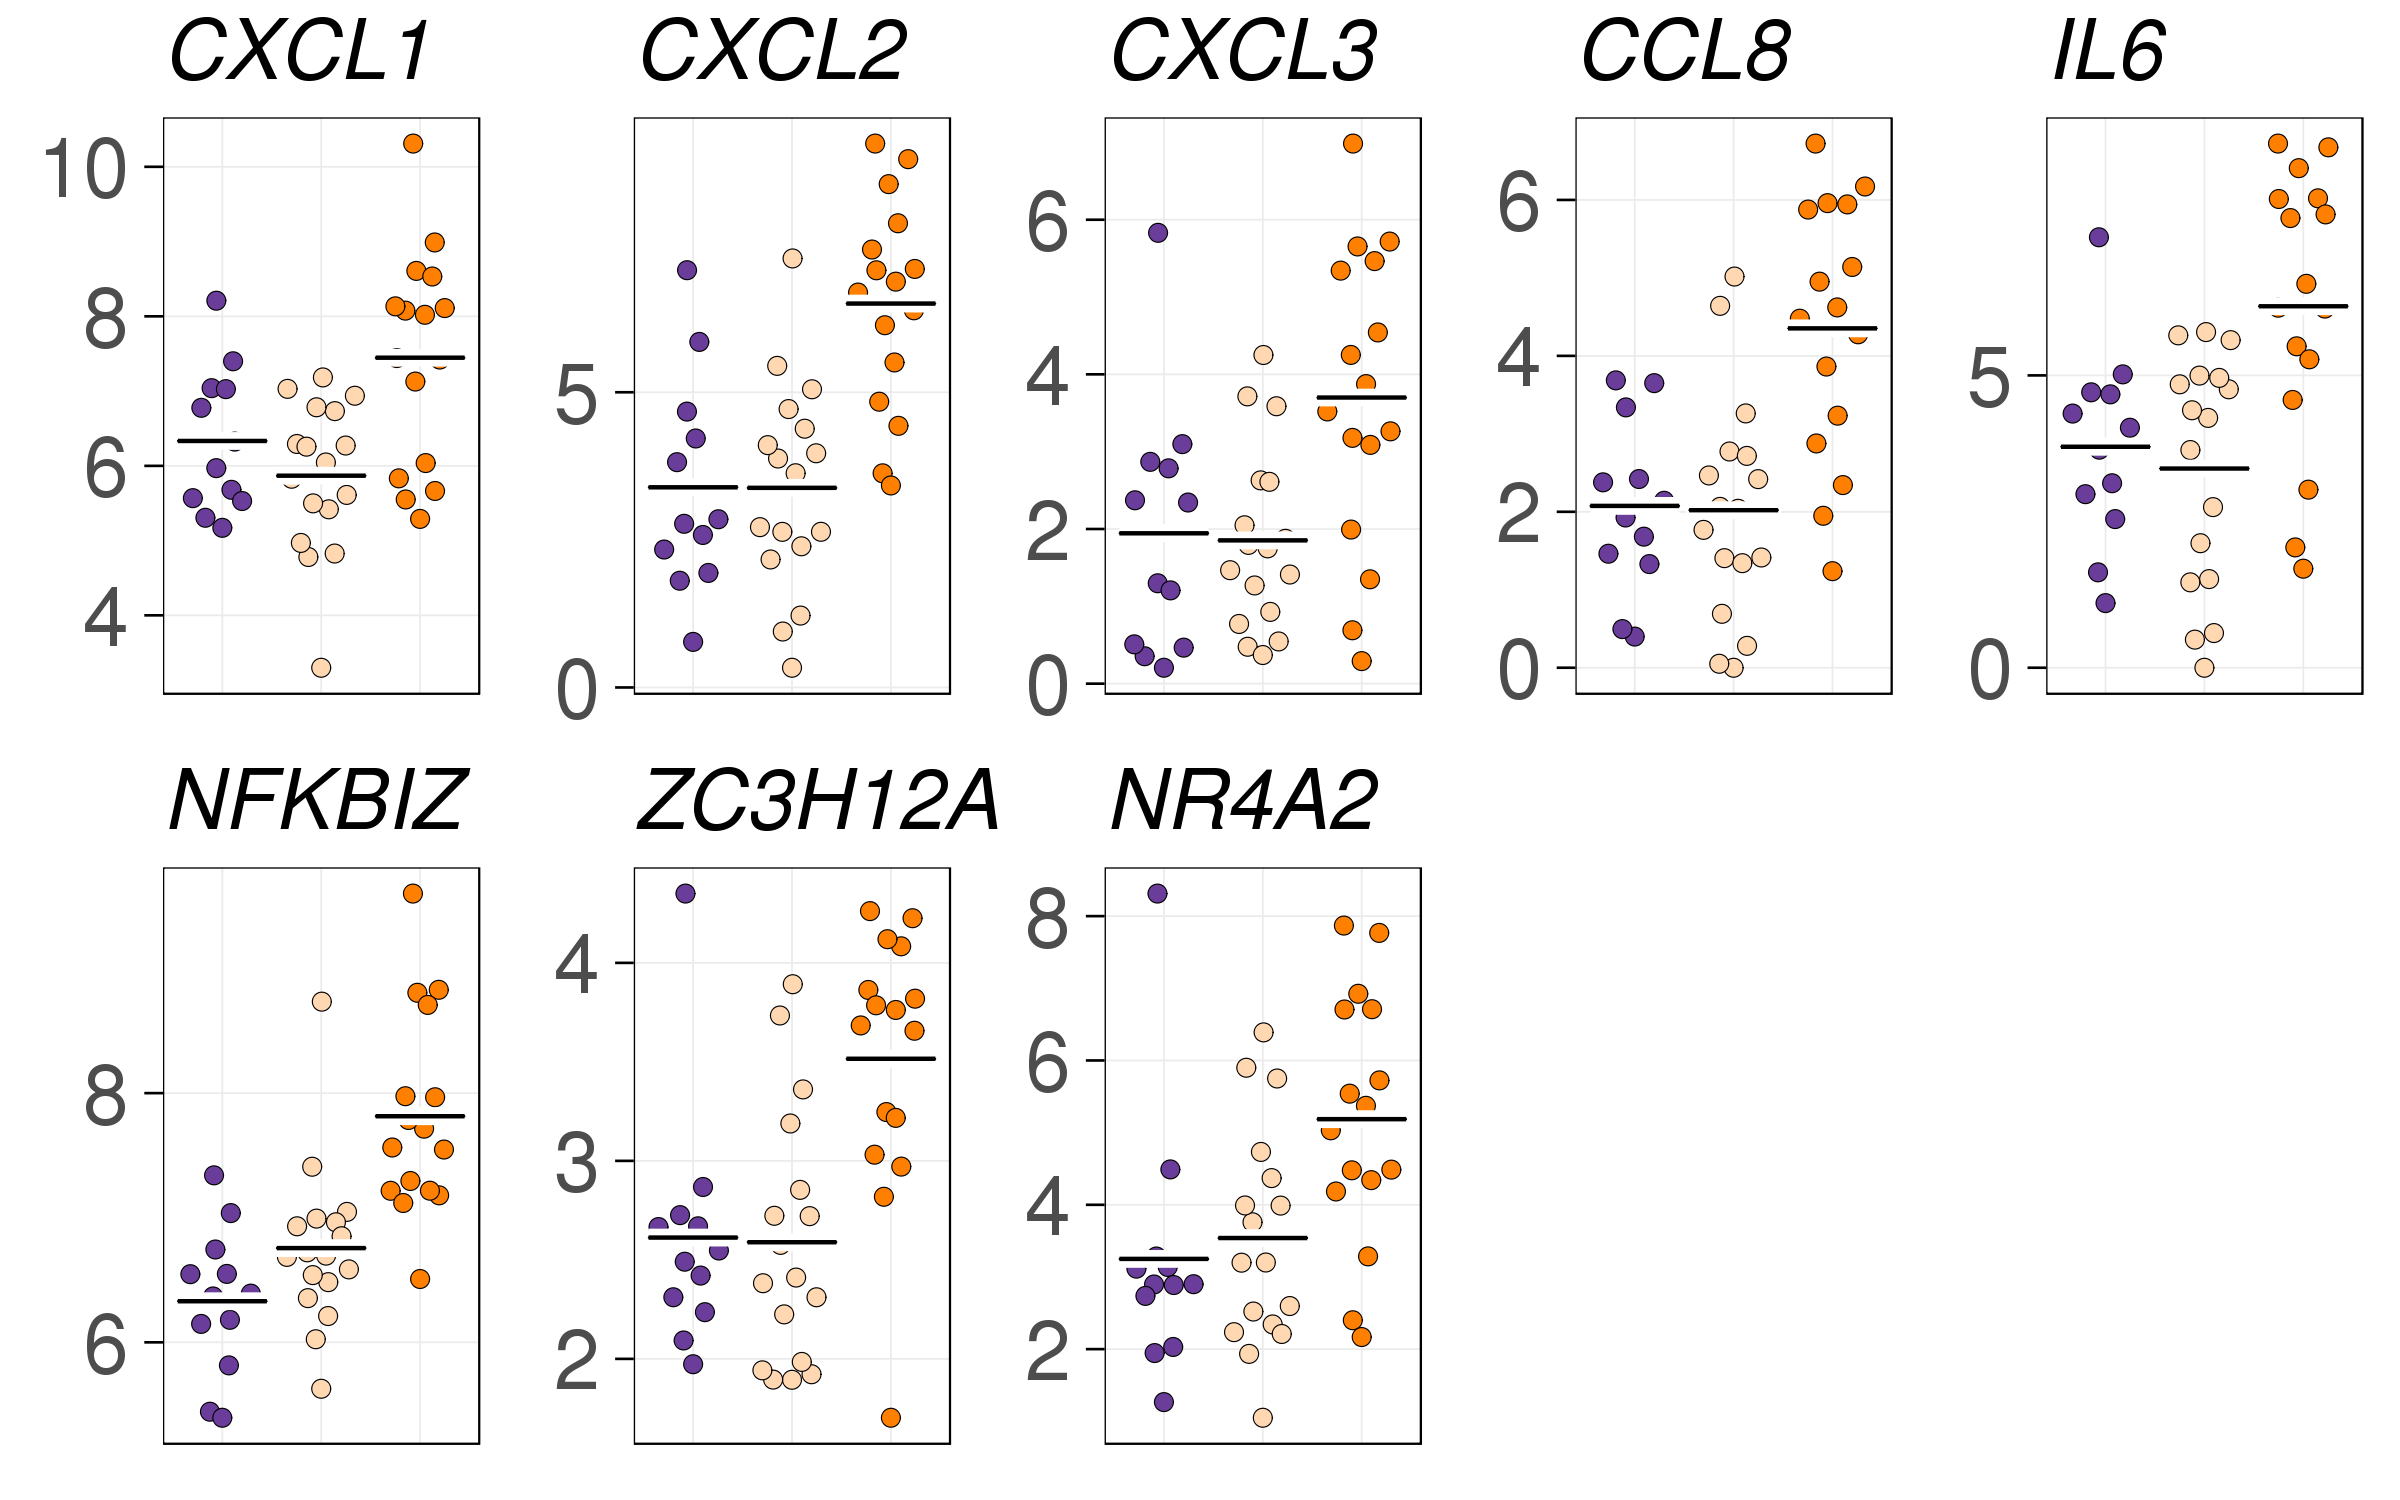

In [50]:
options(repr.plot.width = 8, repr.plot.height = 5)

# this_gene <- c(
#   "LYPD3", "NR4A2", "RERG",
#   "CXCL2", "NFKBIZ", "CCL8", "ZC3H12A", "PTGS2", "MT1G", "IER3", "IL6", "SLC7A2", "CXCL1", "CXCL3"
# )
this_gene <- c(
  "CXCL1", "CXCL2", "CXCL3", "CCL8", "IL6",
  "NFKBIZ", "ZC3H12A", "NR4A2"
)
this_ens <- names(ens83_to_symbol[which(ens83_to_symbol %in% this_gene)])

d <- cbind(
  bulk_meta_fib[,c("sample_id", "status")],
  {
    x <- t(bulk_fib[this_ens,])
    colnames(x) <- ens83_to_symbol[colnames(x)]
    x
  }
)

d <- d %>% tidyr::gather("gene", "value", -sample_id, -status)

d$status <- stringr::str_replace_all(as.character(d$status), "leu", "Leu")
d$status <- factor(as.character(d$status), c("OA", "Leukocyte-poor RA", "Leukocyte-rich RA"))

plots <- lapply(this_gene, function(i) {  
  ggplot(d %>% filter(gene == i)) +
  aes(x = status, y = value, fill = status) +
  geom_quasirandom(shape = 21, size = 2, stroke = 0.2) +
  stat_summary(fun.y = mean, fun.ymin = mean, fun.ymax = mean, geom = "crossbar", width = 0.9, size = 0.8, color = "white") +
  stat_summary(fun.y = mean, fun.ymin = mean, fun.ymax = mean, geom = "crossbar", width = 0.9, size = 0.2) +
  scale_fill_manual(values = meta_colors$Status, name = NULL) +
  scale_y_continuous(breaks = scales::pretty_breaks(3)) +
  labs(x = NULL, y = NULL, title = i) +
  theme(
    legend.position = "none",
    axis.text.x = element_blank(), axis.ticks.x = element_blank(), plot.title = element_text(size = 20, face = "italic", hjust = 0),
    axis.text.y = element_text(size = 20)
  )
#   labs(x = NULL, y = bquote("Log"[2]~"TPM"))
})

# plots[[11]] <- plots[[11]] + theme(legend.position = "right") + guides(fill = guide_legend(override.aes = aes(shape = NA, size = 0), reverse = TRUE, keyheight = 2))

show_plot(res = 300,
  wrap_plots(plots, ncol = 5)
)



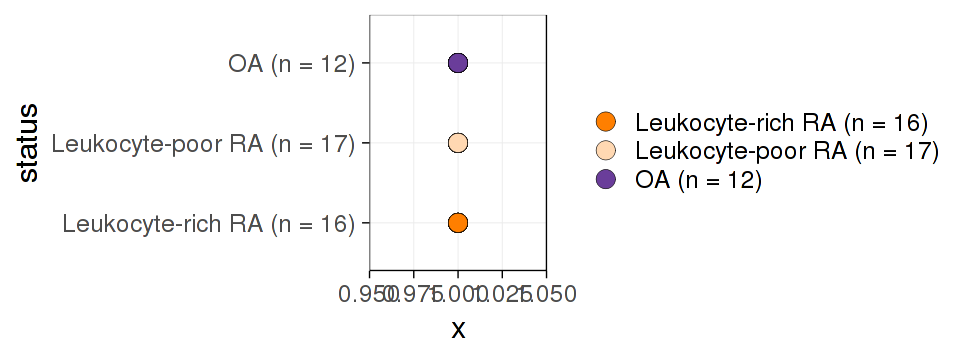

In [51]:
options(repr.plot.width = 8, repr.plot.height = 3)

d2 <- bulk_meta_fib
d2$status <- str_replace_all(d2$status, "leu", " Leu")
d2$status <- str_replace_all(d2$status, "OA", " OA")
d2$status <- sapply(d2$status, function(x) sprintf("%s (n = %s)", x, table(d2$status)[x]))
d2$status <- factor(d2$status)#, c("OA (n = 12)", "Leukocyte-poor RA (n = 17)", "Leukocyte-rich RA (n = 16)"))

levels(d2$status) <- rev(c("OA (n = 12)", "Leukocyte-poor RA (n = 17)", "Leukocyte-rich RA (n = 16)"))
                    
ggplot(d2, aes(x = 1, y = status, fill = status)) +
  geom_point(shape = 21, stroke = 0.2, size = 5) +
  scale_fill_manual(
    values = c("OA (n = 12)" = '#6A3D9A', "Leukocyte-poor RA (n = 17)" = '#FFD8B2', "Leukocyte-rich RA (n = 16)" = '#FF7F00'),
    name = NULL
  )

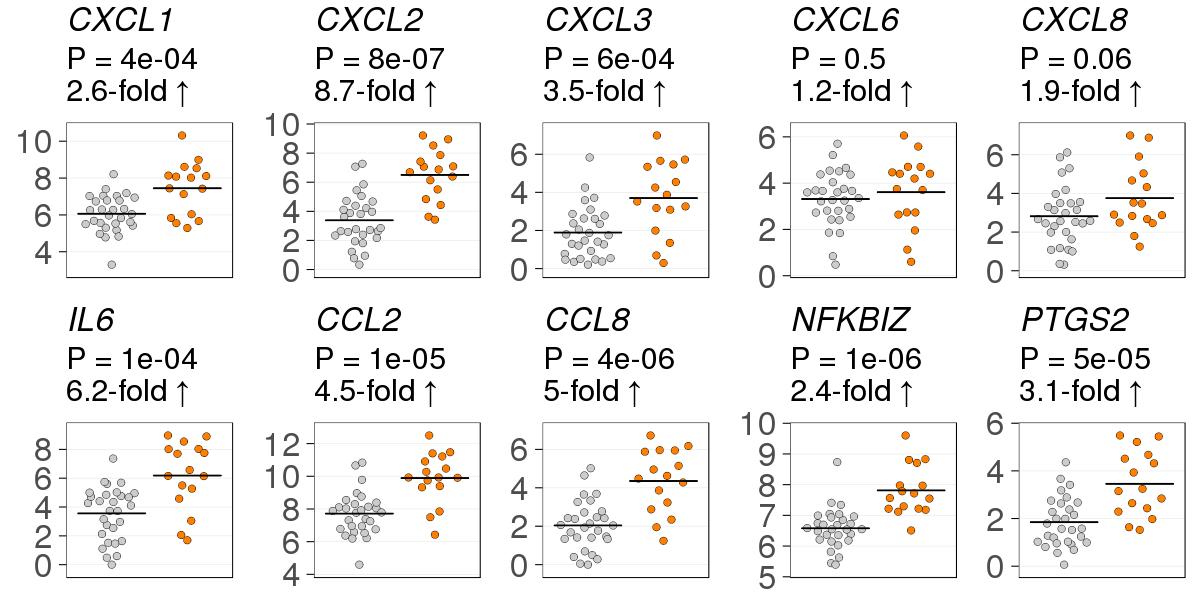

In [52]:
options(repr.plot.width = 10, repr.plot.height = 5)

this_gene <- c(
#   "CXCL1", "CXCL2", "CXCL3", "CCL8", "IL6",
#   "NFKBIZ", "ZC3H12A", "NR4A2"
  "CXCL1", "CXCL2", "CXCL3","CXCL6", "CXCL8",
  "IL6", "CCL2", "CCL8", "NFKBIZ", "PTGS2" # "ZC3H12A", "NR4A2"
)
this_ens <- names(ens83_to_symbol[which(ens83_to_symbol %in% this_gene)])

d <- cbind(
  bulk_meta_fib[,c("sample_id", "status")],
  {
    x <- t(bulk_fib[this_ens,])
    colnames(x) <- ens83_to_symbol[colnames(x)]
    x
  }
)

d <- d %>% tidyr::gather("gene", "value", -sample_id, -status)

d$status2 <- "Non-inflamed arthritis"
ix <- d$status == "leukocyte-rich RA"
d$status2[ix] <- "Inflamed RA"
d$status2 <- factor(d$status2, c("Non-inflamed arthritis", "Inflamed RA"))

scientific_10 <- function(x) {
  parse(text=gsub("e", " %*% 10^", scales::scientific_format()(x)))
}

plots <- lapply(this_gene, function(i) {
  pval <- sprintf("P = %s", signif((bulk_fib_con1_top %>% filter(ID == i))$P.Value, 1))
  fc   <- sprintf("%s-fold ↑", signif(2 ^ (bulk_fib_con1_top %>% filter(ID == i))$logFC, 2))
  ymax <- max((d %>% filter(gene == i))$value)
  ymin <- min((d %>% filter(gene == i))$value)
  ggplot(d %>% filter(gene == i)) +
  aes(x = status2, y = value, fill = status2) +
  geom_quasirandom(shape = 21, size = 2, stroke = 0.2) +
#   annotate(geom = "text", x = 1.5, y = ymax + 2, label = pval, hjust = 0.5, size = 7) +
#   stat_summary(fun.y = mean, fun.ymin = mean, fun.ymax = mean, geom = "crossbar", width = 0.9, size = 0.8, color = "white") +
  stat_summary(fun.y = mean, fun.ymin = mean, fun.ymax = mean, geom = "crossbar", width = 0.9, size = 0.2) +
  scale_fill_manual(
    values = c(
      "Non-inflamed arthritis" = "grey80",
      "Inflamed RA" = RColorBrewer::brewer.pal(9, "Paired")[8] # "grey20"
    ),
    name = NULL
  ) +
  scale_y_continuous(breaks = scales::pretty_breaks(4), expand = c(0.1, 0)) +
  labs(x = NULL, y = NULL, title = i, subtitle = sprintf("%s\n%s", pval, fc)) +
  theme(
    panel.grid.major.x = element_blank(),
    legend.position = "none",
    axis.text.x = element_blank(), axis.ticks.x = element_blank(), plot.title = element_text(size = 20, face = "italic", hjust = 0),
    axis.text.y = element_text(size = 20)
  )
#   labs(x = NULL, y = bquote("Log"[2]~"TPM"))
})

# plots[[11]] <- plots[[11]] + theme(legend.position = "right") + guides(fill = guide_legend(override.aes = aes(shape = NA, size = 0), reverse = TRUE, keyheight = 2))

source("R/002_helper_functions.R")

show_plot(name = "figure5-zhang",
  wrap_plots(plots, ncol = 5)
)



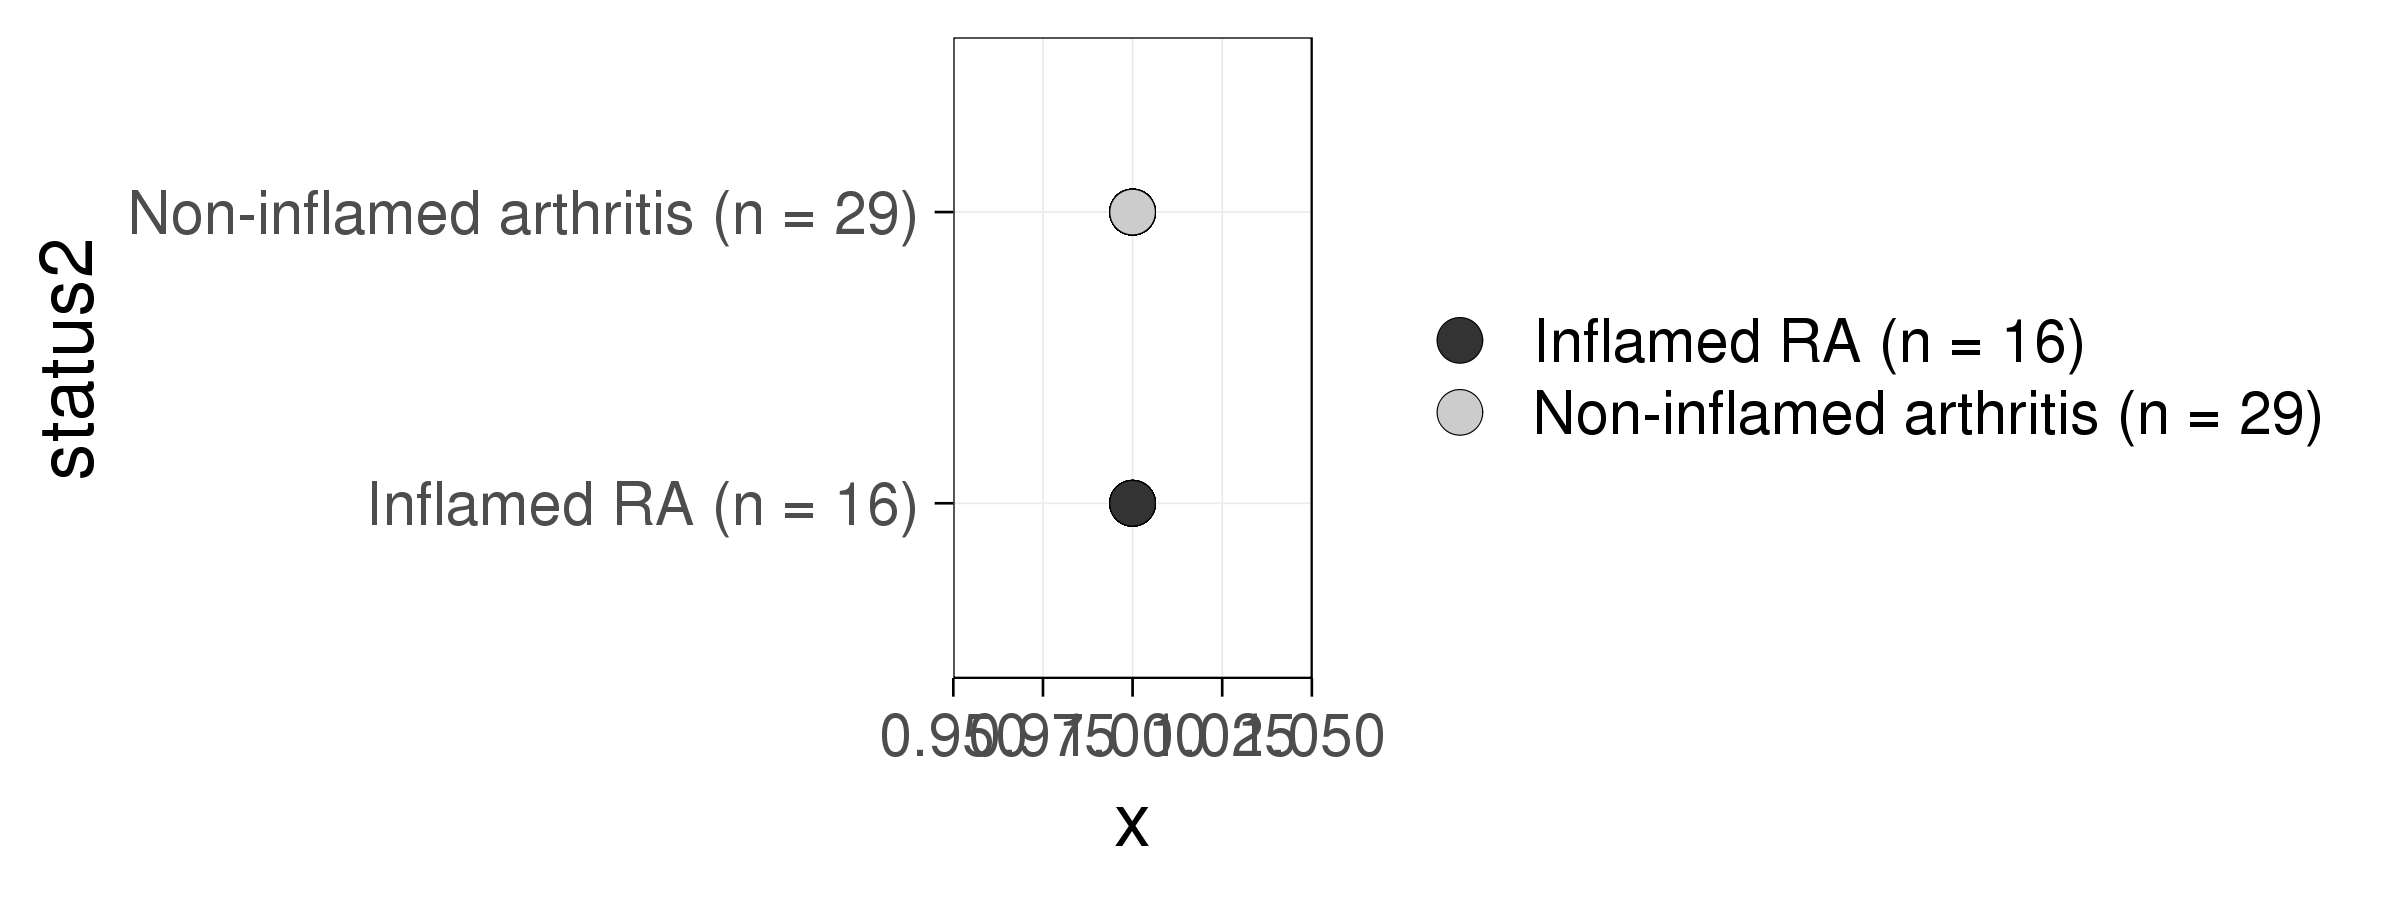

In [53]:
options(repr.plot.width = 8, repr.plot.height = 3)

d2 <- bulk_meta_fib
d2$status2 <- "Non-inflamed arthritis"
ix <- d2$status == "leukocyte-rich RA"
d2$status2[ix] <- "Inflamed RA"
d2$status2 <- sapply(d2$status2, function(x) sprintf("%s (n = %s)", x, table(d2$status2)[x]))
d2$status2 <- factor(d2$status2)#, c("OA (n = 12)", "Leukocyte-poor RA (n = 17)", "Leukocyte-rich RA (n = 16)"))
               
p <- ggplot(d2, aes(x = 1, y = status2, fill = status2)) +
  geom_point(shape = 21, stroke = 0.2, size = 5) +
  scale_fill_manual(
    values = c("Inflamed RA (n = 16)" = 'grey20', "Non-inflamed arthritis (n = 29)" = 'grey80'),
    name = NULL
  )
                     
show_plot(p, res = 300)

In [54]:
meta_colors$status

OA leukocyte-poor RA leukocyte-rich RA 
        "#6A3D9A"         "#FFD8B2"         "#FF7F00"

In [55]:
head(bulk_fib_con1_top)

ID       ensembl_id      logFC    CI.L      CI.R     AveExpr   t       
1 GBP1     ENSG00000117228 2.668269 2.0651577 3.271380  4.968729 8.918211
2 HLA-DOA  ENSG00000204252 2.456692 1.8845969 3.028787  1.807764 8.656212
3 CD74     ENSG00000019582 3.346835 2.5563157 4.137354  8.189499 8.534291
4 HLA-DRA  ENSG00000204287 3.826594 2.9045938 4.748594  6.091036 8.366174
5 B2M      ENSG00000166710 1.218452 0.9193689 1.517534 13.573957 8.212254
6 HLA-DPB1 ENSG00000223865 2.258777 1.6862249 2.831330  5.637778 7.952500
  P.Value      adj.P.Val    B       
1 2.154886e-11 8.964755e-07 15.73337
2 5.000561e-11 1.028587e-06 14.93887
3 7.417339e-11 1.028587e-06 14.56627
4 1.280725e-10 1.332018e-06 14.04963
5 2.116961e-10 1.761396e-06 13.57378
6 4.968785e-10 2.882771e-06 12.76498

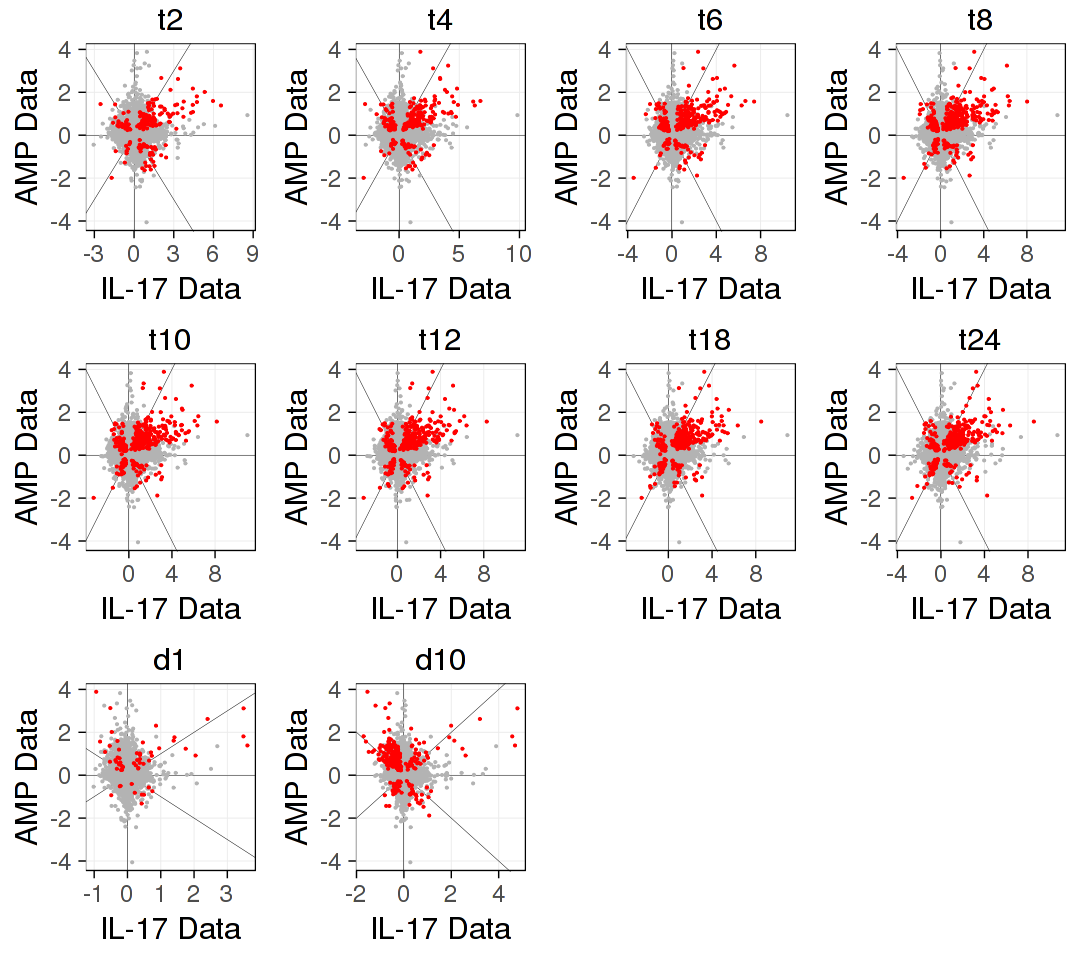

In [56]:
options(repr.plot.width = 9, repr.plot.height = 8)

ens_both <- intersect(d_dose$ensembl_id, bulk_fib_con1_top$ensembl_id)

my_coefs <- setdiff(unique(d_dose$Coef), "Intercept")

my_plot <- function(my_coef) {
  x <- d_dose %>%
  filter(Coef == my_coef) %>%
#   filter(Coef == "t12") %>%
  filter(ensembl_id %in% ens_both) %>%
  # filter(ID %in% genes_both) %>%
  select(-Coef, -signif) %>%
  mutate(data = "dose") %>%
  arrange(ensembl_id)

  y <- bulk_fib_con1_top %>%
  mutate(data = "amp") %>%
  filter(ensembl_id %in% ens_both) %>%
  # filter(ID %in% genes_both) %>%
  arrange(ensembl_id)
  colnames(y) <- sprintf("amp_%s", colnames(y))

  stopifnot(all(x$ensembl_id == y$ensembl_id))

  x <- cbind(x, y)

  x_background <- x %>% filter(!(adj.P.Val < 0.05 & amp_adj.P.Val < 0.05))
  x_signif     <- x %>% filter(adj.P.Val < 0.05 & amp_adj.P.Val < 0.05)

  ggplot() +
  aes(x = logFC, y = amp_logFC) +
  geom_hline(yintercept = 0, size = 0.1) +
  geom_vline(xintercept = 0, size = 0.1) +
  geom_abline(slope = 1, intercept = 0, size = 0.1) +
  geom_abline(slope = -1, intercept = 0, size = 0.1) +
  geom_point(data = x_background, color = "grey70", size = 0.1) +
  geom_point(data = x_signif, size = 0.1, color = "red") +
  # coord_equal() +
  labs(x = "IL-17 Data", y = "AMP Data", title = my_coef)
}

plots <- lapply(my_coefs, my_plot)

wrap_plots(plots)

In [57]:
clean_cols <- function(x) {
  colnames(x) <- str_replace_all(colnames(x), "[()]", "")
  colnames(x) <- str_replace_all(colnames(x), ":", "")
  colnames(x) <- str_replace_all(colnames(x), "status2", "")
  return(x)
}

ix <- which(bulk_meta$cell_type == "T cell")
bulk_meta_tcell <- bulk_meta[ix,]
bulk_tcell <- bulk[,bulk_meta_tcell$sample_id]
dim(bulk_tcell)

bulk_meta_tcell$status2 <- bulk_meta_tcell$status
bulk_meta_tcell$status2[bulk_meta_tcell$status == "leukocyte-rich RA"] <- "RALR"
# bulk_meta_tcell$status2[bulk_meta_tcell$status == "leukocyte-poor RA"] <- "RALP"
bulk_meta_tcell$status2[bulk_meta_tcell$status == "leukocyte-poor RA"] <- "OA"

bulk_tcell_des1 <- clean_cols(with(
  bulk_meta_tcell,
  model.matrix(~ 0 + status2)
))
bulk_tcell_fit1 <- lmFit(object = bulk_tcell, design = bulk_tcell_des1)
bulk_tcell_fit1 <- eBayes(bulk_tcell_fit1)

print(colnames(bulk_tcell_des1))

bulk_tcell_fit1_top <- rbindlist(lapply(unique(bulk_meta_tcell$status2), function(this_coef) {
  retval <- topTable(bulk_tcell_fit1, coef = this_coef, confint = TRUE, number = 1e6)
  retval$gene <- rownames(retval)
  retval$Coef <- this_coef
  retval
}))

bulk_tcell_fit1_top %<>% mutate(
  FC   = 1 / 2^logFC,
  FC.R = 1 / 2^CI.L,
  FC.L = 1 / 2^CI.R
) 

bulk_tcell_con1 <- limma::contrasts.fit(
  fit = bulk_tcell_fit1,
  contrasts = makeContrasts(
    contrasts = c(
      "RALR - OA"
    ),
    levels = bulk_tcell_des1
  )
)
bulk_tcell_con1 <- eBayes(bulk_tcell_con1)

bulk_tcell_con1_top <- topTable(bulk_tcell_con1, coef = 1, confint = TRUE, number = 1e6)
bulk_tcell_con1_top <- cbind(ensembl_id = rownames(bulk_tcell_con1_top), bulk_tcell_con1_top, stringsAsFactors = FALSE)
bulk_tcell_con1_top <- cbind(ID = ens83_to_symbol[rownames(bulk_tcell_con1_top)], bulk_tcell_con1_top, stringsAsFactors = FALSE)
rownames(bulk_tcell_con1_top) <- seq(nrow(bulk_tcell_con1_top))

head(bulk_tcell_con1_top)

bulk_tcell_con1_top %>% filter(ID %in% c("GPR15", "CUX1", "LIFR", "IL6"))


table(bulk_meta_tcell$status)

[1] 41602    47

Warning message:
“Zero sample variances detected, have been offset away from zero”

[1] "OA"   "RALR"


Warning message:
“Zero sample variances detected, have been offset away from zero”

ID       ensembl_id      logFC      CI.L       CI.R       AveExpr   t        
1 GLA      ENSG00000102393  1.7258717  1.3764880  2.0752554  6.229541  9.945323
2 BCAS2    ENSG00000116752  1.0979092  0.8213246  1.3744938  7.214602  7.991926
3 H3F3B    ENSG00000132475  0.6552222  0.4778300  0.8326145 11.262144  7.436474
4 TMEM200A ENSG00000164484 -1.2663692 -1.6379314 -0.8948070  2.642708 -6.861859
5 H2AFZ    ENSG00000164032  0.6316902  0.4457622  0.8176181  8.311586  6.840259
6 STX3     ENSG00000166900 -1.4838206 -1.9408660 -1.0267752  2.844840 -6.536347
  P.Value      adj.P.Val    B        
1 5.279346e-13 2.196314e-08 19.029329
2 3.208837e-10 6.674702e-06 13.085126
3 2.121308e-09 2.941688e-05 11.316187
4 1.525120e-08 1.366967e-04  9.462960
5 1.642910e-08 1.366967e-04  9.392978
6 4.683831e-08 3.247612e-04  8.406964

ID    ensembl_id      logFC       CI.L       CI.R      AveExpr   t         
1 CUX1  ENSG00000257923 -0.25451820 -0.6113499 0.1023135 3.0680649 -1.4360463
2 GPR15 ENSG00000154165  0.40158642 -0.4364897 1.2396626 2.0858014  0.9647361
3 IL6   ENSG00000136244 -0.16408632 -0.7228524 0.3946797 0.7636484 -0.5912285
4 LIFR  ENSG00000113594 -0.08477184 -0.4220175 0.2524739 0.9016584 -0.5060789
  P.Value   adj.P.Val B        
1 0.1578080 0.7976212 -5.330632
2 0.3397609 0.8517370 -5.872421
3 0.5572842 0.9129344 -6.155998
4 0.6152370 0.9372402 -6.201934


leukocyte-poor RA leukocyte-rich RA                OA 
               16                18                13 

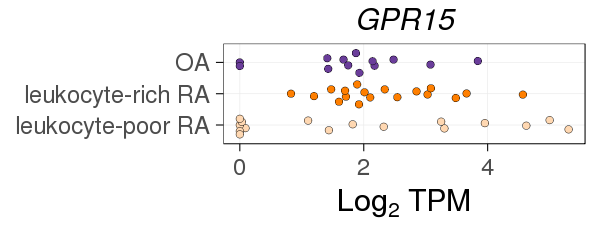

In [58]:
options(repr.plot.width = 5, repr.plot.height = 2)

this_gene <- "GPR15"
this_ens <- names(ens83_to_symbol[which(ens83_to_symbol == this_gene)])
bulk_meta_tcell$mygene <- as.numeric(bulk_tcell[this_ens, ])

p <- ggplot(bulk_meta_tcell) +
aes(x = status, y = mygene, fill = status) +
geom_quasirandom(shape = 21, size = 2, stroke = 0.2) +
scale_fill_manual(values = meta_colors$status, name = NULL, guide = FALSE) +
coord_flip() +
labs(x = NULL, y = bquote("Log"[2]~"TPM"), title = ens83_to_symbol[[this_ens]]) +
theme(plot.title = element_text(face = "italic"))

show_plot(p)

# Gene categories

In [59]:
cats <- readRDS("analysis/limma/cats.rds")

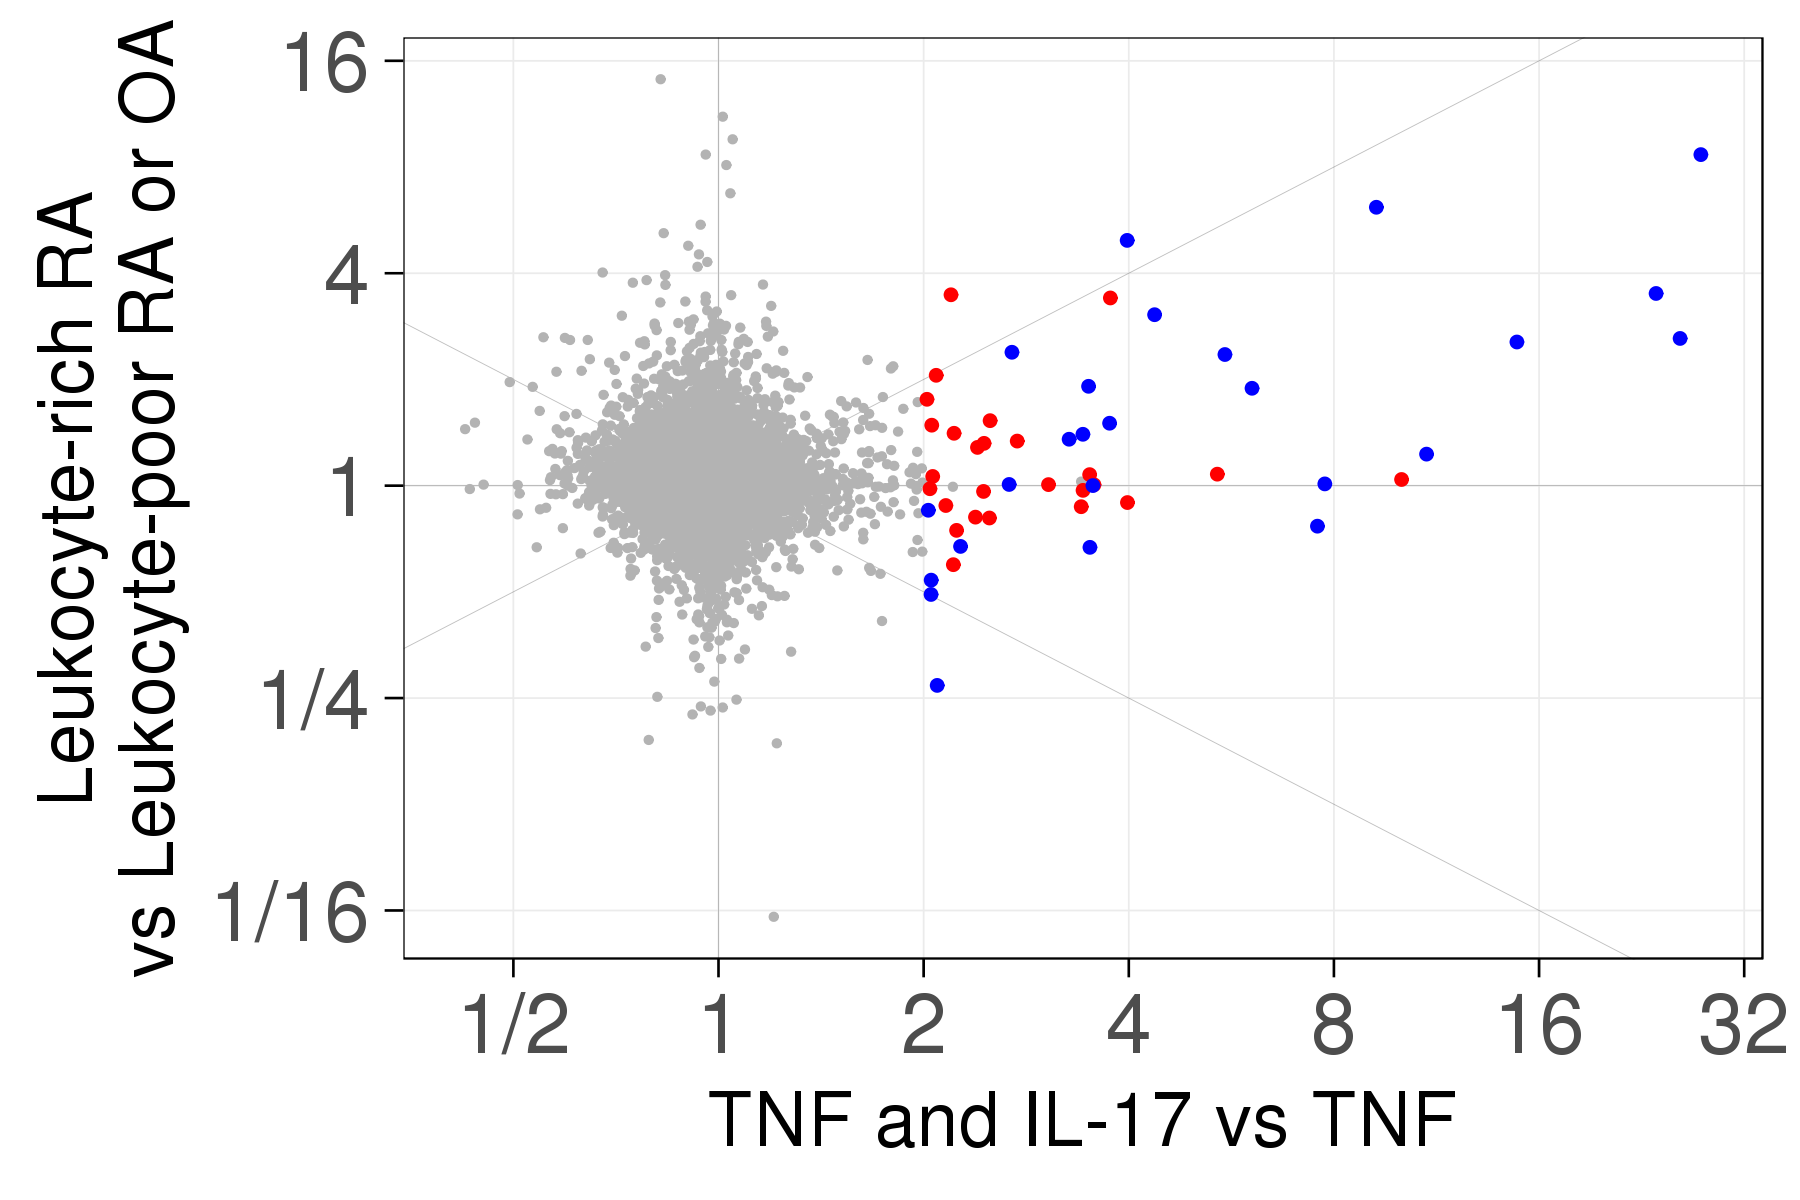

In [60]:
plot_cat <- function(my_coef = "d10", category = NULL) {
  x <- d_dose %>%
  filter(Coef == my_coef) %>%
  filter(ensembl_id %in% ens_both) %>%
  select(-Coef, -signif) %>%
  mutate(data = "dose") %>%
  arrange(ensembl_id)

  y <- bulk_fib_con1_top %>%
  mutate(data = "amp") %>%
  filter(ensembl_id %in% ens_both) %>%
  arrange(ensembl_id)
  colnames(y) <- sprintf("amp_%s", colnames(y))

  stopifnot(all(x$ensembl_id == y$ensembl_id))

  x <- cbind(x, y)

  x_background <- x %>% filter(!(adj.P.Val < 0.05 & amp_adj.P.Val < 0.05))
  # x_signif     <- x %>% filter(adj.P.Val < 0.05 & amp_adj.P.Val < 0.05)
#   x_signif <- x %>% filter(ensembl_id %in% category)
  x_cat1 <- x %>% filter(ensembl_id %in% cats$C1)
  x_cat2 <- x %>% filter(ensembl_id %in% cats$C2)

  ggplot() +
  aes(x = logFC, y = amp_logFC) +
  geom_hline(yintercept = 0, size = 0.1, alpha = 0.25) +
  geom_vline(xintercept = 0, size = 0.1, alpha = 0.25) +
  geom_abline(slope = 1, intercept = 0, size = 0.1, alpha = 0.25) +
  geom_abline(slope = -1, intercept = 0, size = 0.1, alpha = 0.25) +
  geom_point(data = x_background, color = "grey70", size = 0.5) +
  geom_point(data = x_cat1, size = 1, color = "red") +
  geom_point(data = x_cat2, size = 1, color = "blue") +
  scale_y_continuous(
    labels = function(x) fractional(2^x),
    breaks = scales::pretty_breaks(5)
  ) +
  scale_x_continuous(
    labels = function(x) fractional(2^x),
    breaks = scales::pretty_breaks(5)
  ) +
  labs(x = NULL, y = NULL) +
  theme(axis.text = element_text(size = 20), plot.title = element_text(size = 20))
}

options(repr.plot.width = 6, repr.plot.height = 4)

# p1 <- plot_cat(category = cats$C1) + labs(title = "Category C1", y = "Leukocyte-rich RA", x = "TNF and IL-17 vs TNF")
# p2 <- plot_cat(category = cats$C2) + labs(title = "Category C2", x = "TNF and IL-17 vs TNF")

# p1 + p2

p1 <- plot_cat(category = cats$C1) + labs(y = "Leukocyte-rich RA\nvs Leukocyte-poor RA or OA", x = "TNF and IL-17 vs TNF")

show_plot(p1, res = 300)

       
        FALSE TRUE
  FALSE     9   14
  TRUE      1    2
       
        FALSE TRUE
  FALSE     5    9
  TRUE      2    9


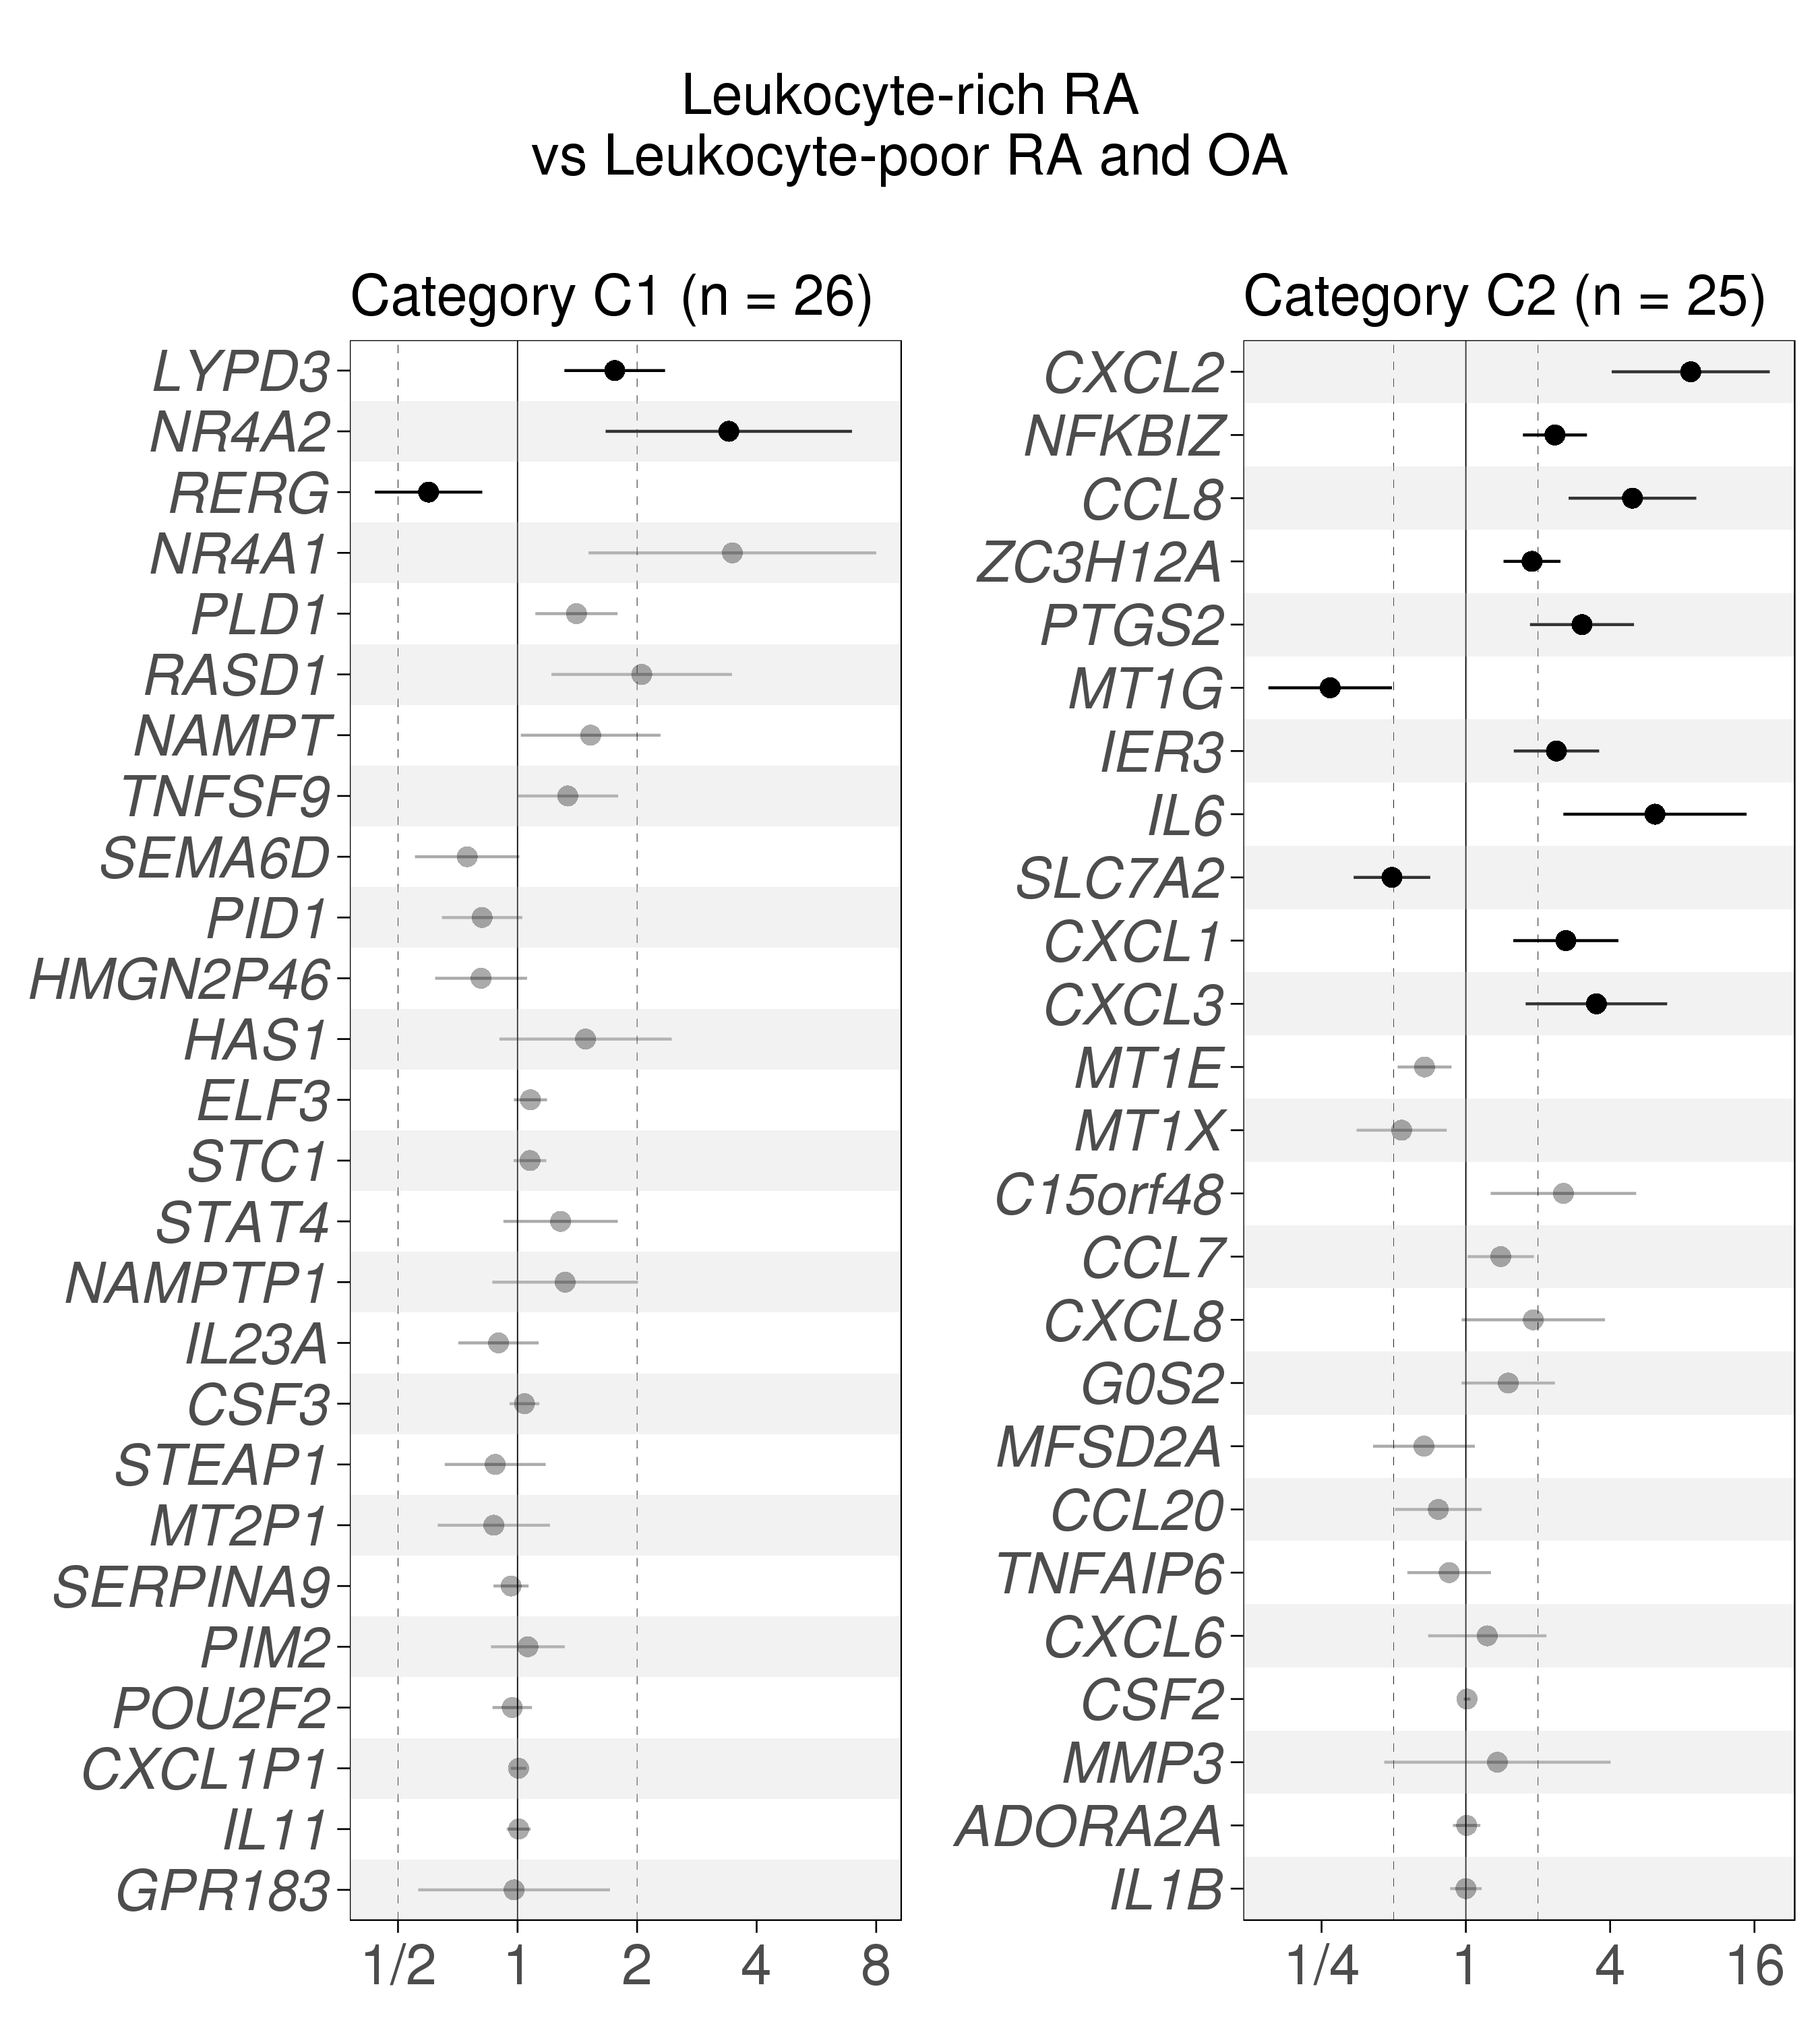

In [61]:
plot_coef <- function(fit1_top, these_genes = c("RASD1", "CXCL1"), title = "TNF") {
  
  d <- fit1_top %>%
  filter(ID %in% these_genes) %>%
#   mutate(ID = factor(as.character(ID), these_genes)) %>%  
  mutate(signif = adj.P.Val < 0.05)
  
  print(with(d, table(adj.P.Val < 0.05, logFC > 0)))
  
  ggplot(d) +
  coord_flip() +
  geom_hline(yintercept = 0, size = 0.2) +
  geom_hline(yintercept = log2(c(1/2, 2)), size = 0.1, linetype = 2) +
  geom_errorbar(
    mapping = aes(x = reorder(ID, -P.Value), ymin = CI.L, ymax = CI.R, alpha = signif),
    width = 0,
    size = 0.5
  ) +
  annotate(
    geom = "rect",
    ymin = -Inf, ymax = Inf,
    xmin = seq(0.5, length(these_genes) - 0.5, by = 2),
    xmax = seq(0.5, length(these_genes) - 0.5, by = 2) + 1,
    fill = "grey80",
    alpha = 0.25
  ) +
  geom_point(
    mapping = aes(x = ID, y = logFC, alpha = signif),
    shape = 19, size = 3.5, stroke = 0
  ) +
  scale_alpha_manual(
    guide = FALSE,
    name = NULL,
    values = c(
      "TRUE" = 1,
      "FALSE" = 0.33
    )
  ) +
  scale_x_discrete(expand = c(0, 0.5)) +
  scale_y_continuous(
    labels = function(x) fractional(2^x),
    breaks = scales::pretty_breaks(5)
  ) +
  labs(title = title, y = NULL, x = NULL) +
  theme(
    legend.title = element_text(size = 18),
    plot.title = element_text(size = 20, hjust = 0),
    legend.position = "right",
    panel.grid.major = element_blank(),
    # panel.grid.major = element_line(size = 0.2, color = "grey80"),
    panel.spacing = unit(1, "lines"),
    axis.text.x = element_text(size = 20),
    axis.text.y = element_text(face = "italic", size = 20),
    strip.text = element_text(face = "italic")
  )
}

options(repr.plot.width = 9, repr.plot.height = 10)

p1 <- plot_coef(bulk_fib_con1_top, these_genes = ens83_to_symbol[cats$C1], title = sprintf("Category C1 (n = %s)", length(cats$C1)))

p2 <- plot_coef(bulk_fib_con1_top, these_genes = ens83_to_symbol[cats$C2], title = sprintf("Category C2 (n = %s)", length(cats$C2)))

main_title <- sprintf(
  "\nLeukocyte-rich RA (n = %s)\nvs Leukocyte-poor RA (n = %s) and OA (n = %s)\n",
  table(bulk_meta_fib$status)["leukocyte-poor RA"],
  table(bulk_meta_fib$status)["leukocyte-rich RA"],
  table(bulk_meta_fib$status)["OA"]
)
main_title <- "\nLeukocyte-rich RA\nvs Leukocyte-poor RA and OA\n"

show_plot(res = 300,
  p1 + p2 + plot_annotation(title = main_title, theme = theme(plot.title = element_text(size = 20, hjust = 0.5)))
)

category n   iwa     
1 C1        26 1.022532
2 C2        25 1.036803
3 C3       370 1.099024
4 C4        13 2.010527
5 C5       201 1.037789

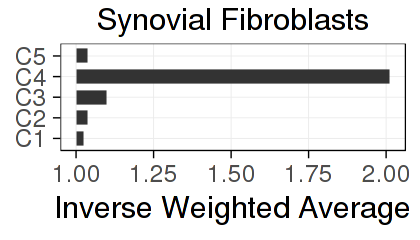

In [62]:
d <- bind_rows(lapply(c("C1", "C2", "C3", "C4", "C5"), function(this_cat) {
  these_ens_ids <- intersect(cats[[this_cat]], rownames(bulk_fib_con1$coefficients))
  mu <- bulk_fib_con1$coefficients[these_ens_ids,1]
  s2 <- bulk_fib_con1$s2.post[these_ens_ids]
  list(category = this_cat, n = length(these_ens_ids), iwa = 2 ^ (sum(mu / s2) / sum(1 / s2)))
}))

d

options(repr.plot.width = 3.5, repr.plot.height = 2)

ggplot(d) +
geom_segment(aes(x = category, xend = category, y = iwa, yend = 1), size = 3, color = "grey20") +
coord_flip() +
labs(x = NULL, y = "Inverse Weighted Average", title = "Synovial Fibroblasts")

In [63]:
length(cats$C4)

[1] 13

In [64]:
bulk_fib[1:5,1:5]

S77       S69        S101     S109     S13     
ENSG00000000003 5.0978763 4.44123141 5.036719 4.679895 4.668597
ENSG00000000005 0.8419991 0.04235439 0.000000 0.000000 2.344960
ENSG00000000419 6.5458457 6.21317724 6.161328 6.493436 5.816776
ENSG00000000457 2.6464299 2.32468907 2.420659 2.954435 2.092156
ENSG00000000460 1.7780931 1.81682952 2.493511 2.354005 2.543972

In [65]:
# unname(ens83_to_symbol[my_genes])

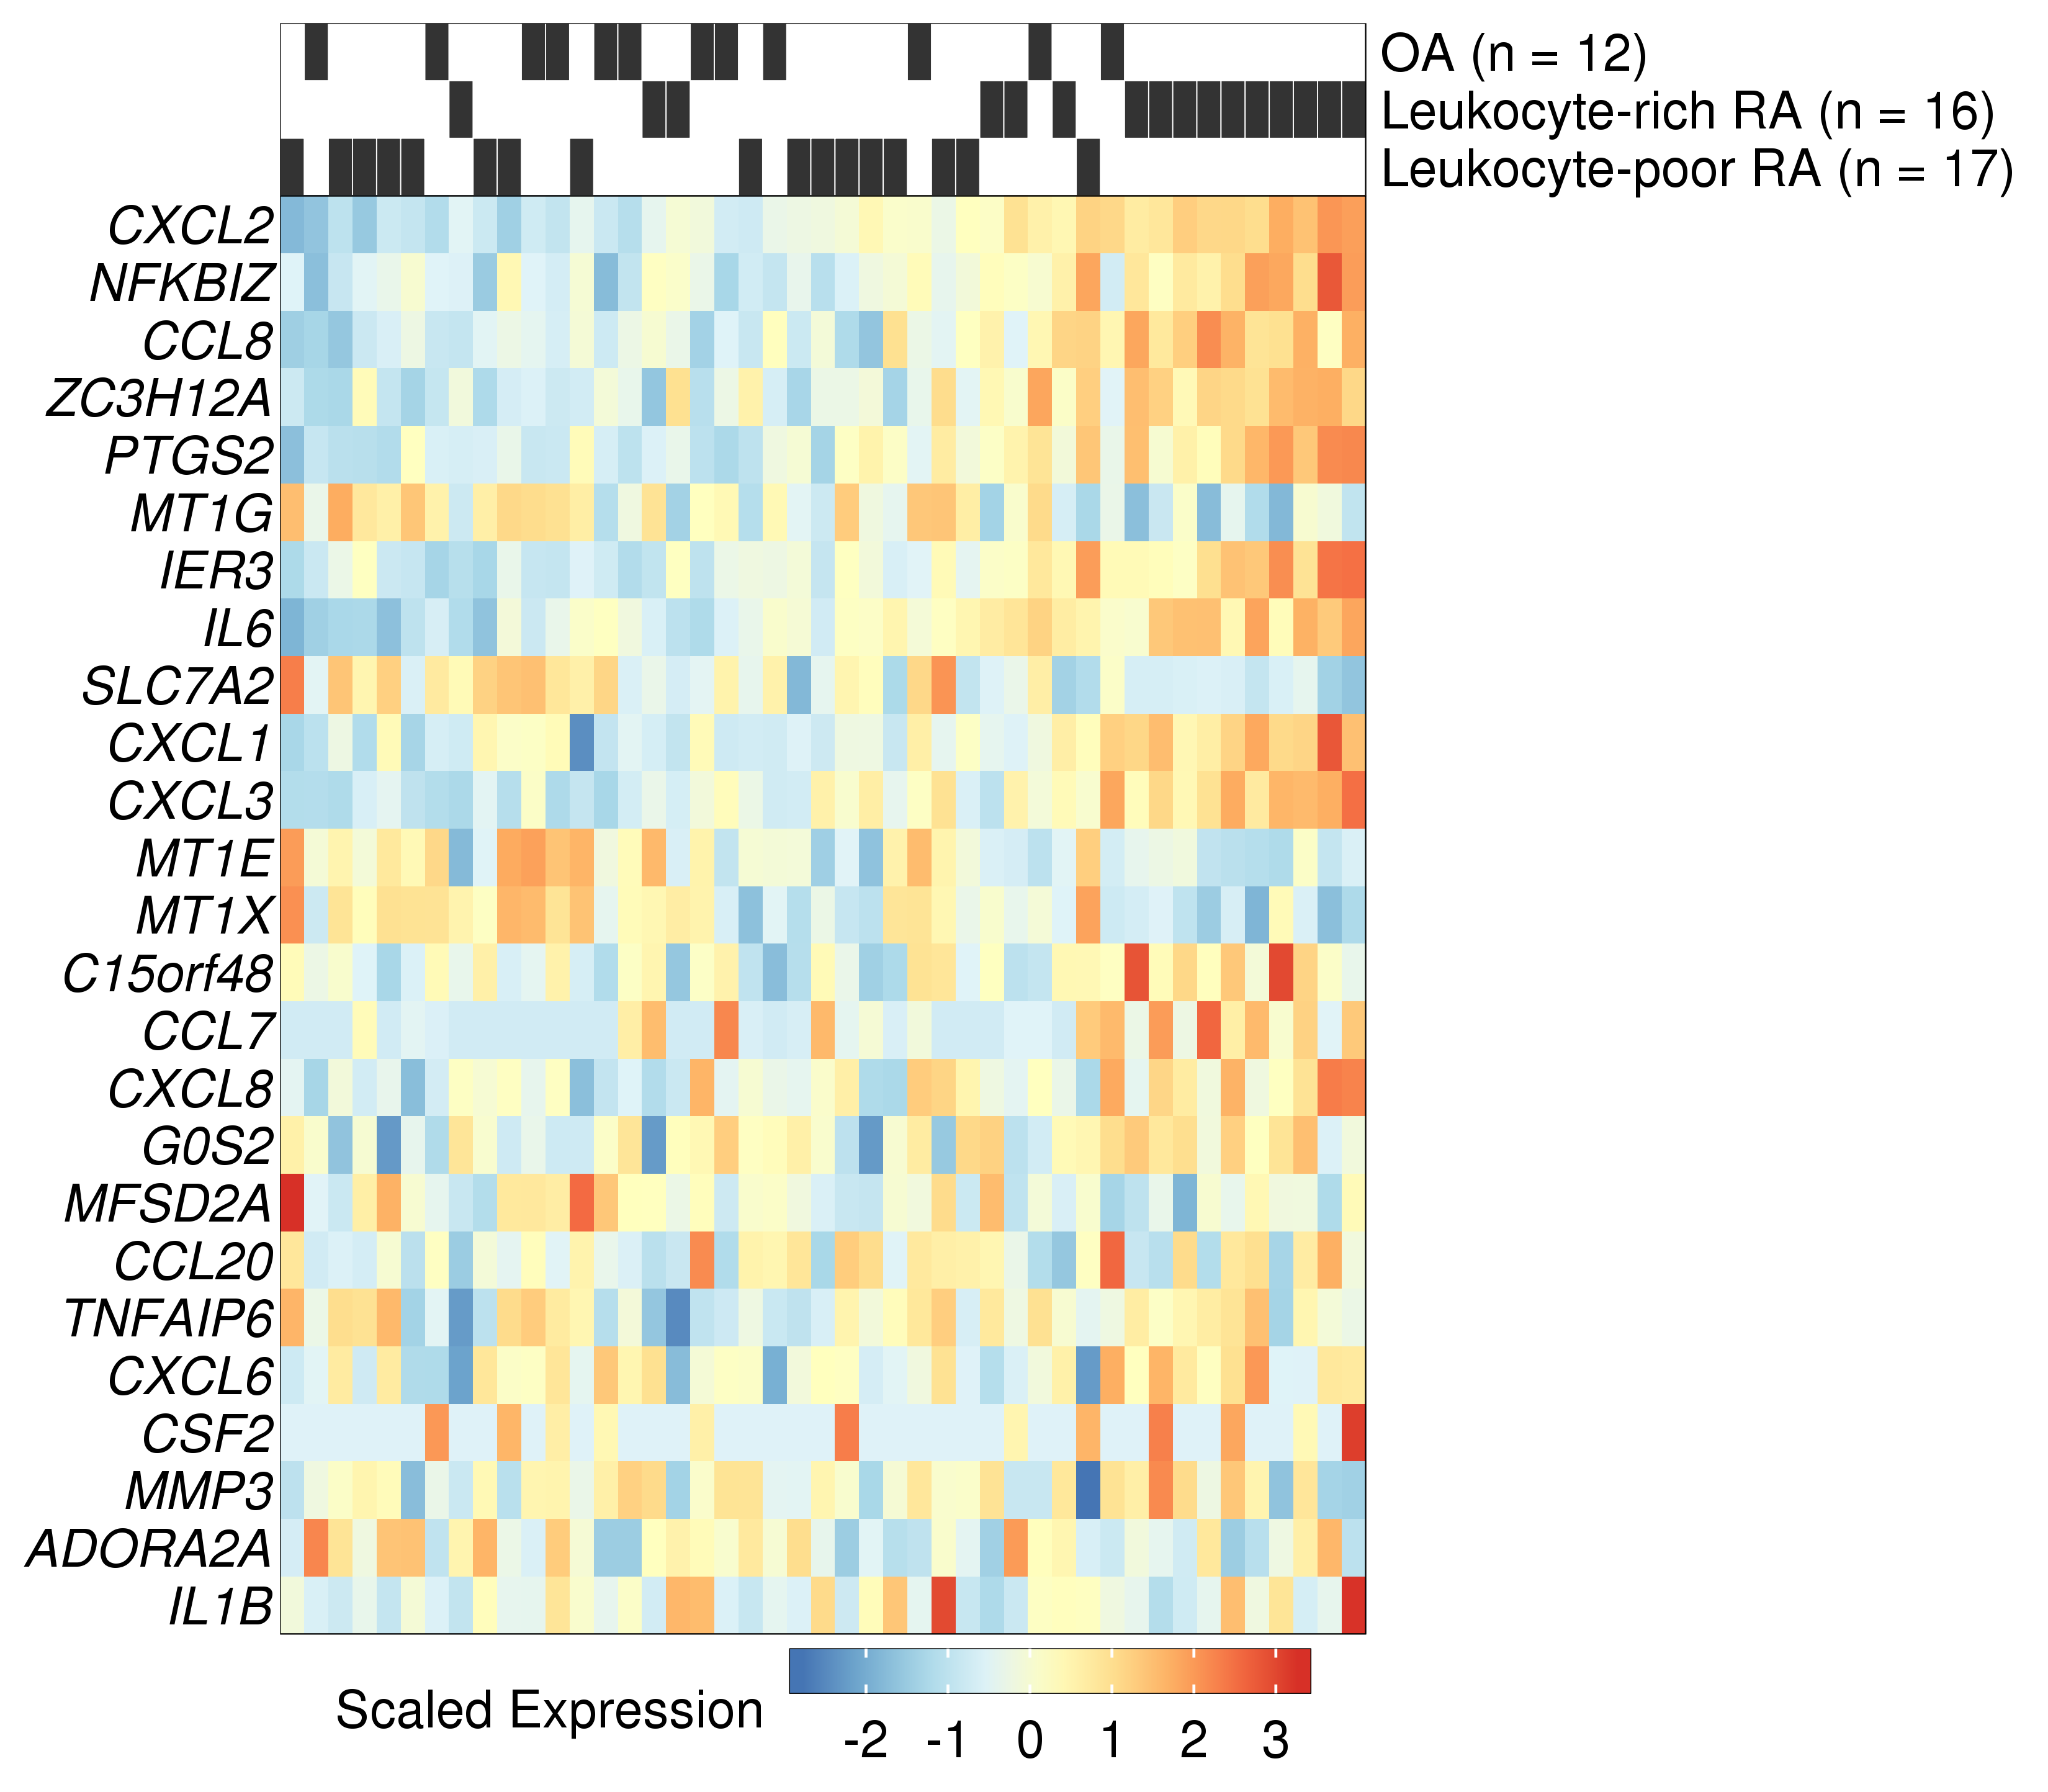

In [66]:
my_genes <- (
  bulk_fib_con1_top %>%
  filter(ensembl_id %in% cats$C2) %>%
  mutate(ID = forcats::fct_reorder(ID, P.Value))
)$ensembl_id

d <- bulk_fib[my_genes,]

d <- d[,(seriate(d, method = "PCA")[[2]])]

sample_names <- colnames(d)

d <- d %>%
scale_rows %>%
melt()

d$Var1 <- forcats::fct_relevel(d$Var1, rev(my_genes))

options(repr.plot.width = 11, repr.plot.height = 4 + length(my_genes) * 0.225)

d2 <- bulk_meta[sample_names,]
d2$status <- str_replace_all(d2$status, "leu", " Leu")
d2$status <- str_replace_all(d2$status, "OA", " OA")
d2$status <- sapply(d2$status, function(x) sprintf("%s (n = %s)", x, table(d2$status)[x]))
d2$sample_id <- factor(d2$sample_id, sample_names)


p3 <- ggplot(d2, aes(sample_id, y = status), fill = "grey20") +
geom_tile(color = "white", size = 0.2) +
theme_void() +
scale_x_discrete(expand = c(0, 0)) +
scale_y_discrete(expand = c(0, 0), position = "right") +
guides(fill = guide_legend(title = NULL, keywidth = 1, keyheight = 1)) +
theme(panel.border = element_rect(fill = NA), axis.text.y = element_text(size = 20, hjust = 0))

p4 <- ggplot(d, aes(Var2, Var1, fill = value)) +
scale_x_discrete(expand = c(0, 0)) +
scale_y_discrete(labels = function(x) ens83_to_symbol[x], expand = c(0, 0)) +
geom_tile() +
theme_void() +
# scale_fill_continuous_diverging(palette = "Blue-Red 3") +
# scale_fill_gradientn(colors = sequential_hcl(palette = "Plasma", n = 100)) +
# scale_fill_scico(palette = "vik") +
scale_fill_gradientn(colors = rev(RColorBrewer::brewer.pal(n = 9, "RdYlBu"))) +
theme(panel.border = element_rect(fill = NA), axis.text.y = element_text(size = 20, face = "italic"), legend.position = "bottom", legend.text = element_text(size = 20), legend.title = element_text(size = 20)) +
guides(fill = guide_colorbar(barwidth = 14, title = "Scaled Expression", frame.colour = "black", frame.linewidth = 0.5, ticks.linewidth = 1.5))

show_plot(p3 / p4 + plot_layout(heights = c(1, length(my_genes) / 3)), res = 300)

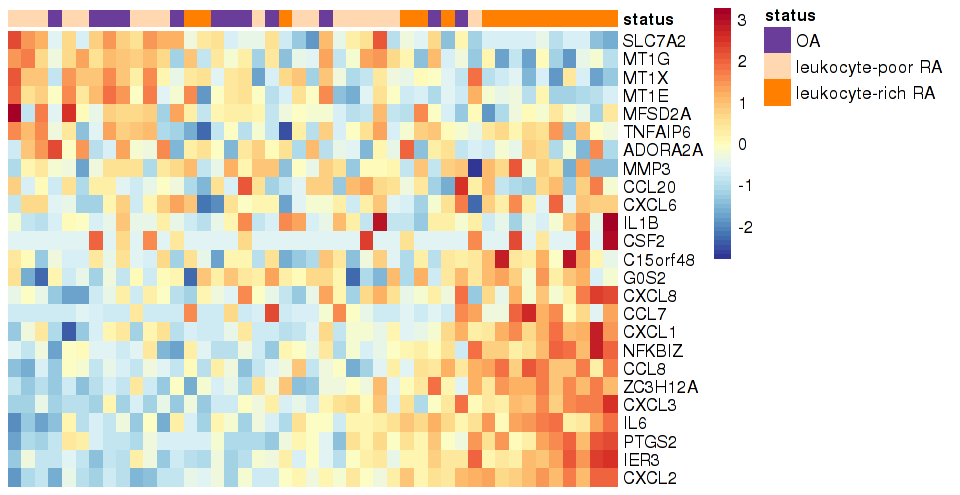

In [67]:
il17_genes <- my_genes

options(repr.plot.width = 8, repr.plot.height = 1 + length(il17_genes) * 0.125)


il17_mat <- winsorize(scale_rows(bulk_fib[cats$C2, ]), 4)
rownames(il17_mat) <- ens83_to_symbol[rownames(il17_mat)]

il17_mat_order <- seriate(il17_mat, method = "PCA")
# il17_mat_order <- seriate(scale_rows(il17_mat) + 10, method = "BEA_TSP")
il17_mat <- il17_mat[
  il17_mat_order[[1]],
  il17_mat_order[[2]]
]

il17_genes_sorted <- il17_genes[il17_mat_order[[1]]]

paletteLength <- 50
myColor <- colorRampPalette(rev(RColorBrewer::brewer.pal(n = 11, name = "RdYlBu")))(paletteLength)
# use floor and ceiling to deal with even/odd length pallettelengths
myBreaks <- c(
  seq(min(il17_mat), 0, length.out = ceiling(paletteLength / 2) + 1), 
  seq(max(il17_mat) / paletteLength, max(il17_mat), length.out = floor(paletteLength / 2))
)

annotation_row <- d_dose %>%
filter(ID %in% rownames(il17_mat) & Coef == "d10") %>%
melt(id.vars = c("ID"), measure.vars = c("logFC"))
rownames(annotation_row) <- annotation_row$ID

pheatmap(
  color = myColor,
  breaks = myBreaks,
  show_colnames = FALSE,
  cluster_cols = FALSE,
  cluster_rows = FALSE,
  annotation_colors = meta_colors,
  mat = il17_mat,
  border_color = NA,
  annotation_col = bulk_meta_fib[,c("status"),drop=FALSE]
  # annotation_row = annotation_row[,c("value"), drop = FALSE]
)

In [68]:
sapply(cats, length)

C1    C2    C3    C4    C5  None 
   26    25   370    13   202 19243

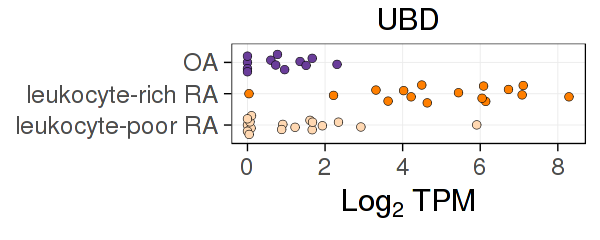

In [69]:
options(repr.plot.width = 5, repr.plot.height = 2)

this_ens <- "ENSG00000213886"
bulk_meta_fib$mygene <- as.numeric(bulk_fib[this_ens, ])

ggplot(bulk_meta_fib) +
aes(x = status, y = mygene, fill = status) +
geom_quasirandom(shape = 21, size = 2, stroke = 0.2) +
scale_fill_manual(values = meta_colors$status, name = NULL, guide = FALSE) +
coord_flip() +
labs(x = NULL, y = bquote("Log"[2]~"TPM"), title = ens83_to_symbol[[this_ens]])

In [70]:
g1 <- (
  d_dose %>%
  filter(Coef == "t6" & logFC > log2(2) & adj.P.Val < 0.01)
)$ensembl_id

g2 <- (
  d_dose %>%
  filter(Coef == "d10" & logFC > log2(3) & adj.P.Val < 0.01)
)$ensembl_id

il17_genes <- g2
# il17_genes <- intersect(g2, g1)
# il17_genes <- union(g2, g1)


# Remove CXCL1P1
ix <- ens83_to_symbol[il17_genes] == "CXCL1P1"
il17_genes <- il17_genes[!ix]

length(il17_genes)

print(head(unname(ens83_to_symbol[il17_genes]), 20))

[1] 26

 [1] "ZC3H12A"  "CXCL2"    "CXCL1"    "CXCL3"    "C15orf48" "NFKBIZ"  
 [7] "IL6"      "CSF2"     "CXCL8"    "ELF3"     "CCL20"    "MFSD2A"  
[13] "PTGS2"    "CXCL6"    "CSF3"     "G0S2"     "STC1"     "NR4A2"   
[19] "CCL7"     "POU2F2"  


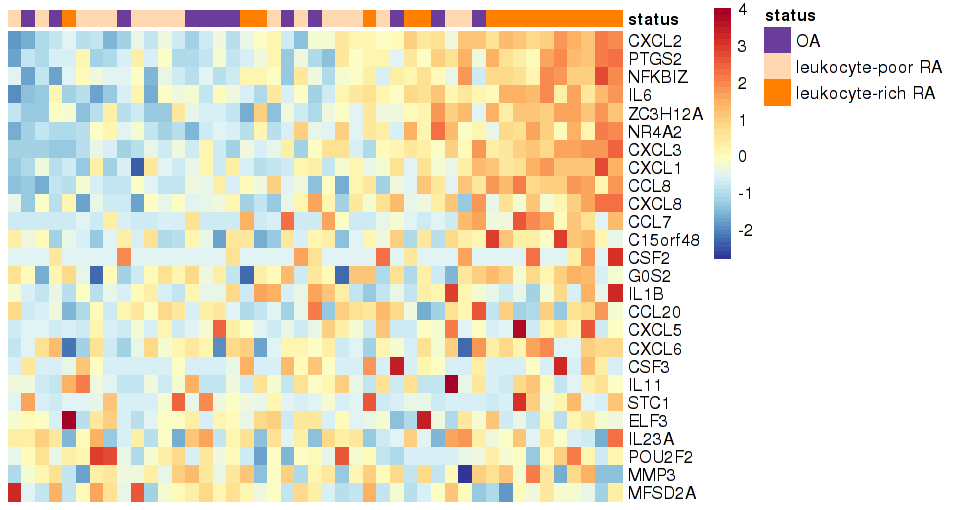

In [71]:
options(repr.plot.width = 8, repr.plot.height = 1 + length(il17_genes) * 0.125)

il17_mat <- winsorize(scale_rows(bulk_fib[il17_genes, ]), 4)
rownames(il17_mat) <- ens83_to_symbol[rownames(il17_mat)]

il17_mat_order <- seriate(il17_mat, method = "PCA")
# il17_mat_order <- seriate(scale_rows(il17_mat) + 10, method = "BEA_TSP")
il17_mat <- il17_mat[
  il17_mat_order[[1]],
  il17_mat_order[[2]]
]

il17_genes_sorted <- il17_genes[il17_mat_order[[1]]]

paletteLength <- 50
myColor <- colorRampPalette(rev(RColorBrewer::brewer.pal(n = 11, name = "RdYlBu")))(paletteLength)
# use floor and ceiling to deal with even/odd length pallettelengths
myBreaks <- c(
  seq(min(il17_mat), 0, length.out = ceiling(paletteLength / 2) + 1), 
  seq(max(il17_mat) / paletteLength, max(il17_mat), length.out = floor(paletteLength / 2))
)

annotation_row <- d_dose %>%
filter(ID %in% rownames(il17_mat) & Coef == "d10") %>%
melt(id.vars = c("ID"), measure.vars = c("logFC"))
rownames(annotation_row) <- annotation_row$ID

pheatmap(
  color = myColor,
  breaks = myBreaks,
  show_colnames = FALSE,
  cluster_cols = FALSE,
  cluster_rows = FALSE,
  annotation_colors = meta_colors,
  mat = il17_mat,
  border_color = NA,
  annotation_col = bulk_meta_fib[,c("status"),drop=FALSE]
  # annotation_row = annotation_row[,c("value"), drop = FALSE]
)

# NGFR

In [72]:
this_id <- names(which(ens83_to_symbol == "NGFR"))

this_id %in% rownames(bulk_fib)

cors <- as.numeric(cor(x = as.numeric(bulk_fib[this_id,]), y = t(bulk_fib)))
names(cors) <- rownames(bulk_fib)
cors <- head(cors[order(abs(cors), decreasing = TRUE)], 30 + 1)
head(cors)

ngfr_genes <- names(cors)

[1] TRUE

Warning message in cor(x = as.numeric(bulk_fib[this_id, ]), y = t(bulk_fib)):
“the standard deviation is zero”

ENSG00000064300 ENSG00000171206 ENSG00000140391 ENSG00000164096 ENSG00000255690 
      1.0000000       0.6950455       0.6588330       0.6587533       0.6572570 
ENSG00000198523 
      0.6555043

ENSG00000064300 ENSG00000171206 ENSG00000140391 ENSG00000164096 ENSG00000255690 
         "NGFR"         "TRIM8"        "TSPAN3"        "C4orf3"          "TRIL" 
ENSG00000198523 ENSG00000127951 ENSG00000110442 ENSG00000143429 ENSG00000124731 
          "PLN"          "FGL2"        "COMMD9"        "LSP1P4"         "TREM1" 
ENSG00000182149 ENSG00000184682 ENSG00000152931 ENSG00000127837 ENSG00000165795 
         "IST1"              NA         "PART1"          "AAMP"         "NDRG2" 
ENSG00000101220 ENSG00000117600 ENSG00000149564 ENSG00000255302 ENSG00000224982 
     "C20orf27"        "PLPPR4"          "ESAM"          "EID1"       "TMEM233" 
ENSG00000125144 ENSG00000101384 ENSG00000123243 ENSG00000130592 ENSG00000162998 
         "MT1G"          "JAG1"         "ITIH5"          "LSP1"          "FRZB" 
ENSG00000122862 ENSG00000167641 ENSG00000109265 ENSG00000198417 ENSG00000130528 
         "SRGN"      "PPP1R14A"      "KIAA1211"          "MT1F"           "HRC" 
ENSG00000145147 
        "SL

[1] TRUE

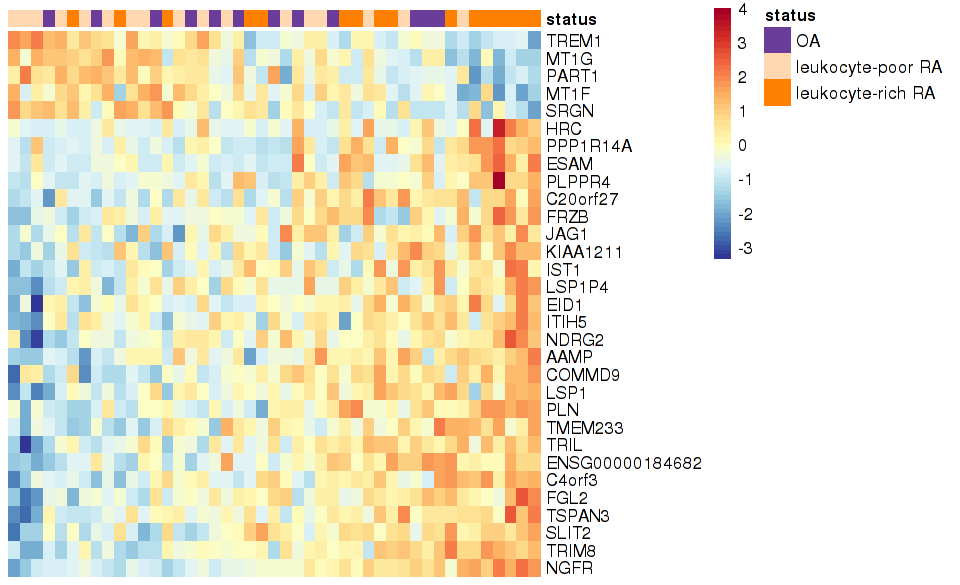

In [73]:
options(repr.plot.width = 8, repr.plot.height = 1 + length(ngfr_genes) * 0.125)

ngfr_mat <- winsorize(scale_rows(bulk_fib[ngfr_genes, ]), 4)

ix <- print(ens83_to_symbol[rownames(ngfr_mat)])
ix[is.na(ix)] <- names(ix[is.na(ix)])

all(rownames(ngfr_mat) %in% names(ens83_to_symbol))
# rownames(ngfr_mat) <- ens83_to_symbol[rownames(ngfr_mat)]
rownames(ngfr_mat) <- unname(ix)

ngfr_mat_order <- seriate(ngfr_mat, method = "PCA")
# ngfr_mat_order <- seriate(scale_rows(ngfr_mat) + 10, method = "BEA_TSP")
ngfr_mat <- ngfr_mat[
  ngfr_mat_order[[1]],
  ngfr_mat_order[[2]]
]

ngfr_genes_sorted <- ngfr_genes[ngfr_mat_order[[1]]]

paletteLength <- 50
myColor <- colorRampPalette(rev(RColorBrewer::brewer.pal(n = 11, name = "RdYlBu")))(paletteLength)
# use floor and ceiling to deal with even/odd length pallettelengths
myBreaks <- c(
  seq(min(ngfr_mat), 0, length.out = ceiling(paletteLength / 2) + 1), 
  seq(max(ngfr_mat) / paletteLength, max(ngfr_mat), length.out = floor(paletteLength / 2))
)

annotation_row <- d_dose %>%
filter(ID %in% rownames(ngfr_mat) & Coef == "d10") %>%
melt(id.vars = c("ID"), measure.vars = c("logFC"))

rownames(annotation_row) <- annotation_row$ID

pheatmap(
  color = myColor,
  breaks = myBreaks,
  show_colnames = FALSE,
  cluster_cols = FALSE,
  cluster_rows = FALSE,
  annotation_colors = meta_colors,
  mat = ngfr_mat,
  border_color = NA,
  annotation_col = bulk_meta_fib[,c("status"),drop=FALSE]
  # annotation_row = annotation_row[,c("value"), drop = FALSE]
)

In [74]:
dim(il17_mat)

[1] 26 45

ENSG00000144802 
           8603

ENSG00000108342 
           3507

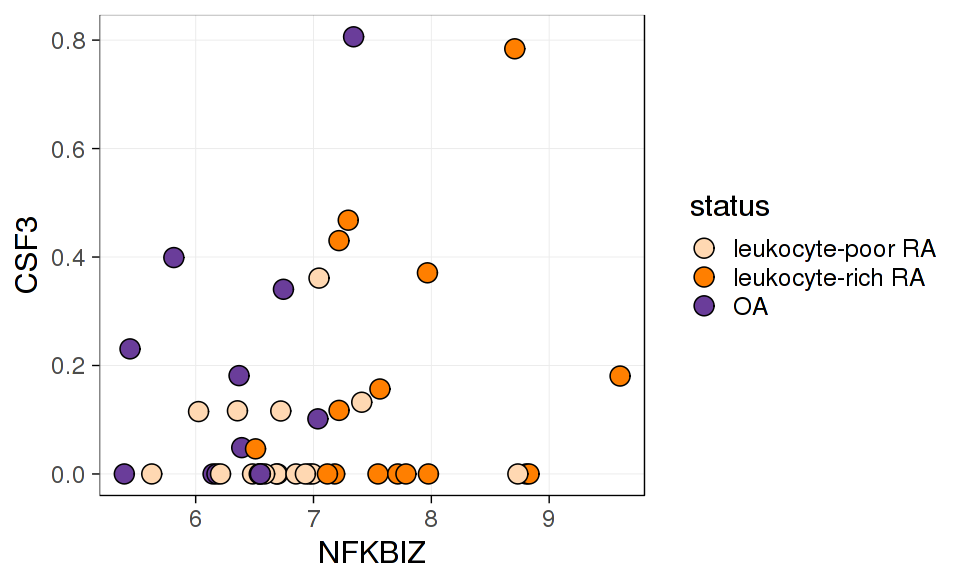

In [75]:

which(ens83_to_symbol == "NFKBIZ")
which(ens83_to_symbol == "CSF3")

bulk_meta_fib$NFKBIZ <- as.numeric(bulk_fib["ENSG00000144802",])
bulk_meta_fib$CSF3 <- as.numeric(bulk_fib["ENSG00000108342",])

ggplot(bulk_meta_fib) +
geom_point(aes(x = NFKBIZ, y = CSF3, fill = status), shape = 21, size = 5) +
scale_fill_manual(values = meta_colors$status)

## Walsh 2017

In [76]:
walsh <- fread("zcat /PHShome/ks38/work/notebooks/public-data/data-raw/GSE89408_log2cpm.tsv.gz")
walsh_rownames <- walsh$V1
walsh$V1 <- NULL
walsh <- as.matrix(walsh)
rownames(walsh) <- walsh_rownames

colnames(walsh) %<>% str_replace_all(., "RA", "rheumatoid_arthritis") %>%
str_replace_all(., "OA", "osteoarthritis") %>%
str_replace_all(., "AG", "arthralgia") %>%
str_replace_all(., "undiff", "undifferentiated_arthritis")

walsh[1:5,1:5]

normal_tissue_1 normal_tissue_2 normal_tissue_3
5S_rRNA             0.0000000       0.0000000       0.0000000      
7SK                 3.6845943       4.3318026       5.1034008      
7SK:ENSG00000260682 0.5229027       0.8392954       1.8651680      
A1BG                1.0902561       0.4001849       0.6437292      
A1BG-AS1            1.7692579       0.3528189       0.7990463      
                    normal_tissue_4 normal_tissue_5
5S_rRNA             0.0000000       0.000000       
7SK                 3.7370262       3.552753       
7SK:ENSG00000260682 0.8150445       1.724193       
A1BG                0.8556738       0.959029       
A1BG-AS1            1.9121975       1.748462

In [77]:
walsh_meta <- as.data.frame(fread("zcat /PHShome/ks38/work/notebooks/public-data/data-raw/GSE89408_meta.tsv.gz"))

walsh_rownames <- str_replace_all(walsh_meta$V1, " ", "_") %>%
str_replace_all(., "healthy", "normal")
walsh_meta$V1 <- NULL
rownames(walsh_meta) <- walsh_rownames

x <- table(walsh_meta$disease)
walsh_meta$diseasen <- factor(walsh_meta$disease)
levels(walsh_meta$diseasen) <- sprintf("%s (n=%s)", names(x), x)

walsh_meta[1:5,]

geo_accession sex age disease acpa type    percent_common
normal_tissue_1 GSM2370970    M   13  Normal  NA   healthy 99.83487      
normal_tissue_2 GSM2370971    F   32  Normal  NA   healthy 99.52296      
normal_tissue_3 GSM2370972    M   22  Normal  NA   healthy 99.96942      
normal_tissue_4 GSM2370973    M   47  Normal  NA   healthy 99.95107      
normal_tissue_5 GSM2370974    M   27  Normal  NA   healthy 99.92049      
                diseasen     
normal_tissue_1 Normal (n=28)
normal_tissue_2 Normal (n=28)
normal_tissue_3 Normal (n=28)
normal_tissue_4 Normal (n=28)
normal_tissue_5 Normal (n=28)

In [78]:
all(rownames(walsh_meta) == colnames(walsh))

[1] TRUE

In [79]:
rownames(walsh)[which(rownames(walsh) == "IL8")] <- "CXCL8"

In [80]:
ens83_to_symbol[il17_genes][which(!unname(ens83_to_symbol[il17_genes]) %in% rownames(walsh))]

named character(0)

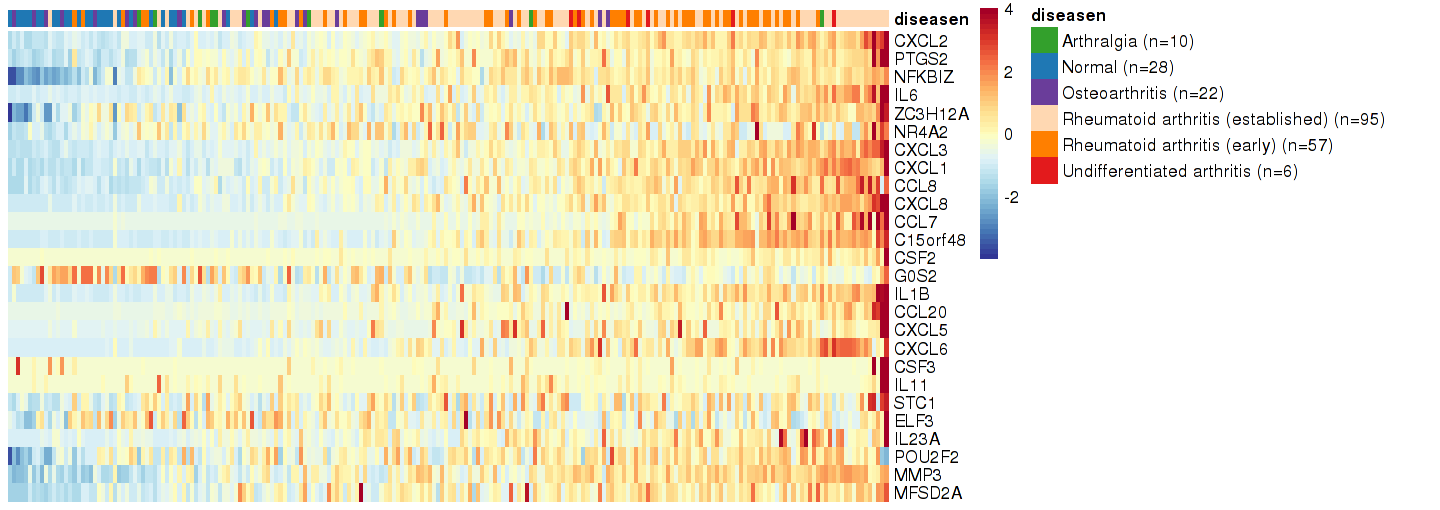

In [81]:
walsh_genes <- intersect(rownames(walsh), c("IL8", ens83_to_symbol[il17_genes]))

walsh_mat <- winsorize(scale_rows(walsh[walsh_genes, ]), 4)

walsh_mat_order <- seriate(walsh_mat, method = "PCA")
# walsh_mat_order <- seriate(scale_rows(walsh_mat) + 10, method = "BEA_TSP")
walsh_mat <- walsh_mat[
  rev(walsh_mat_order[[1]]),
  walsh_mat_order[[2]]
]

walsh_mat <- walsh_mat[ens83_to_symbol[il17_genes_sorted],]

paletteLength <- 50
myColor <- colorRampPalette(rev(RColorBrewer::brewer.pal(n = 11, name = "RdYlBu")))(paletteLength)
# use floor and ceiling to deal with even/odd length pallettelengths
myBreaks <- c(
  seq(min(walsh_mat), 0, length.out = ceiling(paletteLength / 2) + 1), 
  seq(max(walsh_mat) / paletteLength, max(walsh_mat), length.out = floor(paletteLength / 2))
)

options(repr.plot.width = 12, repr.plot.height = 1 + length(walsh_genes) * 0.125)
pheatmap(
  color = myColor,
  breaks = myBreaks,
  show_colnames = FALSE,
  cluster_cols = FALSE,
  cluster_rows = FALSE,
  annotation_colors = meta_colors,
  mat = walsh_mat,
  annotation_col = walsh_meta[,c("diseasen"),drop=FALSE],
  border_color = NA
  # annotation_row = annotation_row[,c("value"), drop = FALSE]
)

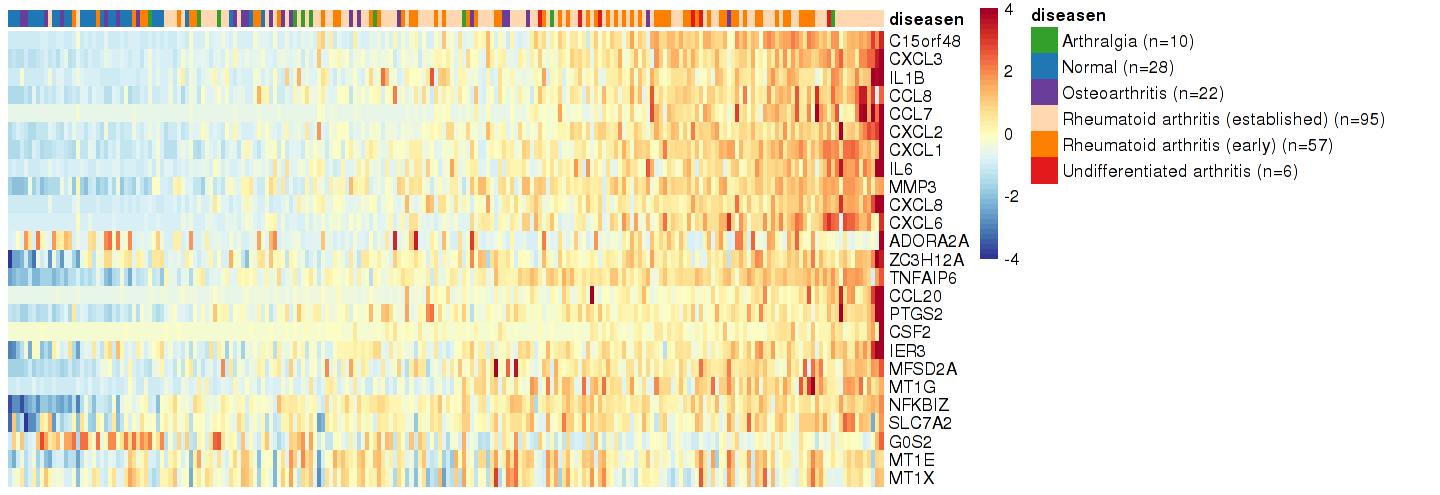

In [82]:
walsh_genes <- intersect(rownames(walsh), ens83_to_symbol[cats$C2])

walsh_mat <- winsorize(scale_rows(walsh[walsh_genes, ]), 4)

walsh_mat_order <- seriate(walsh_mat, method = "PCA")
# walsh_mat_order <- seriate(scale_rows(walsh_mat) + 10, method = "BEA_TSP")
walsh_mat <- walsh_mat[
  walsh_mat_order[[1]],
  rev(walsh_mat_order[[2]])
]

paletteLength <- 50
myColor <- colorRampPalette(rev(RColorBrewer::brewer.pal(n = 11, name = "RdYlBu")))(paletteLength)
# use floor and ceiling to deal with even/odd length pallettelengths
myBreaks <- c(
  seq(min(walsh_mat), 0, length.out = ceiling(paletteLength / 2) + 1), 
  seq(max(walsh_mat) / paletteLength, max(walsh_mat), length.out = floor(paletteLength / 2))
)

options(repr.plot.width = 12, repr.plot.height = 1 + length(walsh_genes) * 0.125)
pheatmap(
  color = myColor,
  breaks = myBreaks,
  show_colnames = FALSE,
  cluster_cols = FALSE,
  cluster_rows = FALSE,
  annotation_colors = meta_colors,
  mat = walsh_mat,
  annotation_col = walsh_meta[,c("diseasen"),drop=FALSE],
  border_color = NA
  # annotation_row = annotation_row[,c("value"), drop = FALSE]
)

In [83]:
print(walsh_genes)

 [1] "ADORA2A"  "C15orf48" "CCL20"    "CCL7"     "CCL8"     "CSF2"    
 [7] "CXCL1"    "CXCL2"    "CXCL3"    "CXCL6"    "G0S2"     "IER3"    
[13] "IL1B"     "IL6"      "CXCL8"    "MFSD2A"   "MMP3"     "MT1E"    
[19] "MT1G"     "MT1X"     "NFKBIZ"   "PTGS2"    "SLC7A2"   "TNFAIP6" 
[25] "ZC3H12A" 


In [91]:
head(walsh)

normal_tissue_1 normal_tissue_2 normal_tissue_3
5S_rRNA             0.0000000       0.00000000      0.0000000      
7SK                 3.6845943       4.33180265      5.1034008      
7SK:ENSG00000260682 0.5229027       0.83929537      1.8651680      
A1BG                1.0902561       0.40018492      0.6437292      
A1BG-AS1            1.7692579       0.35281890      0.7990463      
A1CF                0.0000000       0.03042338      0.0000000      
                    normal_tissue_4 normal_tissue_5 normal_tissue_6
5S_rRNA             0.0000000       0.000000        0.0000000      
7SK                 3.7370262       3.552753        3.5185325      
7SK:ENSG00000260682 0.8150445       1.724193        2.3929136      
A1BG                0.8556738       0.959029        0.6212894      
A1BG-AS1            1.9121975       1.748462        1.8122231      
A1CF                0.0000000       0.000000        0.0000000      
                    normal_tissue_7 normal_tissue_8 normal_tissue_9
5S_rRNA             0.000000        0.000000        0.000000       
7SK                 5.034823        4.348105        0.000000       
7SK:ENSG00000260682 1.574760        1.590496        0.000000       
A1BG                0.664240        1.088592        1.403111       
A1BG-AS1            1.493520        2.011970        0.000000       
A1CF                0.000000        0.000000        0.000000       
                    normal_tissue_10 ⋯ rheumatoid_arthritis_tissue_143
5S_rRNA             0.0000000        ⋯ 0.00000000                     
7SK                 3.5409321        ⋯ 6.10730910                     
7SK:ENSG00000260682 0.7099872        ⋯ 2.51963613                     
A1BG                1.6746315        ⋯ 0.44607047                     
A1BG-AS1            1.8849858        ⋯ 1.01905162                     
A1CF                0.0000000        ⋯ 0.04291564                     
                    rheumatoid_arthritis_tissue_144
5S_rRNA             0.000000                       
7SK                 7.018038                       
7SK:ENSG00000260682 2.334404                       
A1BG                1.004136                       
A1BG-AS1            1.296658                       
A1CF                0.000000                       
                    rheumatoid_arthritis_tissue_145
5S_rRNA             0.03141201                     
7SK                 4.92606166                     
7SK:ENSG00000260682 1.61056374                     
A1BG                0.41162006                     
A1BG-AS1            0.26155196                     
A1CF                1.11545371                     
                    rheumatoid_arthritis_tissue_146
5S_rRNA             0.04505302                     
7SK                 6.34645580                     
7SK:ENSG00000260682 2.31459587                     
A1BG                0.89256161                     
A1BG-AS1            1.93477208                     
A1CF                0.00000000                     
                    rheumatoid_arthritis_tissue_147
5S_rRNA             0.04113504                     
7SK                 5.85083429                     
7SK:ENSG00000260682 2.18971638                     
A1BG                0.90125525                     
A1BG-AS1            1.61047977                     
A1CF                0.00000000                     
                    rheumatoid_arthritis_tissue_148
5S_rRNA             0.03505006                     
7SK                 6.35112802                     
7SK:ENSG00000260682 2.00990859                     
A1BG                0.76084993                     
A1BG-AS1            1.33612746                     
A1CF                0.00000000                     
                    rheumatoid_arthritis_tissue_149
5S_rRNA             0.00000000                     
7SK                 4.49011297                     
7SK:ENSG00000260682 1.70646270                     
A1BG                0.91285021                     
A1BG-AS1       

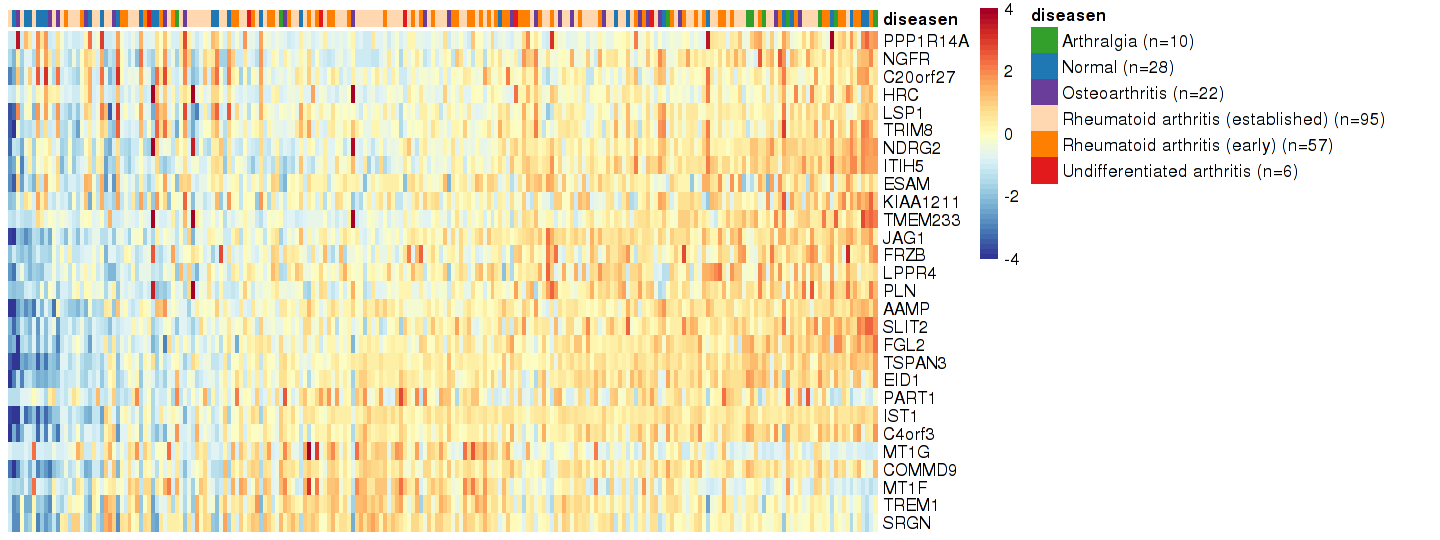

In [92]:
ngfr_symbols <- unname(ens75_to_symbol[ngfr_genes])
ngfr_symbols <- intersect(rownames(walsh), ngfr_symbols)

walsh_mat <- winsorize(scale_rows(walsh[ngfr_symbols, ]), 4)

walsh_mat_order <- seriate(walsh_mat, method = "PCA")
# walsh_mat_order <- seriate(scale_rows(walsh_mat) + 10, method = "BEA_TSP")
walsh_mat <- walsh_mat[
  walsh_mat_order[[1]],
  rev(walsh_mat_order[[2]])
]

paletteLength <- 50
myColor <- colorRampPalette(rev(RColorBrewer::brewer.pal(n = 11, name = "RdYlBu")))(paletteLength)
# use floor and ceiling to deal with even/odd length pallettelengths
myBreaks <- c(
  seq(min(walsh_mat), 0, length.out = ceiling(paletteLength / 2) + 1), 
  seq(max(walsh_mat) / paletteLength, max(walsh_mat), length.out = floor(paletteLength / 2))
)

options(repr.plot.width = 12, repr.plot.height = 1 + length(ngfr_symbols) * 0.125)
pheatmap(
  color = myColor,
  breaks = myBreaks,
  show_colnames = FALSE,
  cluster_cols = FALSE,
  cluster_rows = FALSE,
  annotation_colors = meta_colors,
  mat = walsh_mat,
  annotation_col = walsh_meta[,c("diseasen"),drop=FALSE],
  border_color = NA
  # annotation_row = annotation_row[,c("value"), drop = FALSE]
)

In [93]:
dim(walsh_mat)

[1]  28 218

In [94]:
# walsh_dat <- walsh_mat %>% melt(id.vars = NULL)
# colnames(walsh_dat) <- c("Var1", "Var2", "value")
# # head(walsh_dat)

# walsh_dat$Var1 <- factor(as.character(walsh_dat$Var1), rev(levels(walsh_dat$Var1)))

# p1 <- ggplot() +
# geom_tile(
#   data = walsh_dat,
#   mapping = aes(y = Var1, x = Var2, fill = value)
# ) +
# scale_fill_scico_auto(walsh_dat$value, palette = "roma") +
# # geom_vline(xintercept = c(9.5, 18.5), color = "white", size = 0.75) +
# labs(x = NULL, y = NULL) +
# theme_void() +
# theme(
#   axis.text.x = element_blank(),
# #   axis.text.y = element_blank(),
#   axis.text.y = element_text(face = "italic", size = 6),
#   axis.ticks.x = element_blank(),
#   axis.ticks.y = element_blank(),
#   legend.position = "bottom"
# ) +
# guides(fill = guide_colorbar(title = NULL, barheight = 0.5, barwidth = 10)) +
# # coord_flip() +
# # coord_cartesian(xlim = c(0, 50)) +
# NULL

# # options(repr.plot.width = 5, repr.plot.height = 3)
# # show_plot(p1)

# walsh_dat2 <- data.frame(
#   Var2 = rownames(walsh_meta),
#   Var1 = walsh_meta$diseasen,
#   stringsAsFactors = FALSE
# )
# # head(walsh_dat2)

# p2 <- ggplot() +
# geom_tile(
#   data = walsh_dat2,
#   mapping = aes(y = 0, x = Var2, fill = Var1)
# ) +
# scale_fill_manual(values = meta_colors$diseasen, name = NULL) +
# # scale_fill_scico_auto(walsh_dat$value, palette = "vik") +
# # geom_vline(xintercept = c(9.5, 18.5), color = "white", size = 0.75) +
# labs(x = NULL, y = NULL) +
# theme_void() +
# theme(
#   axis.text.x = element_blank(),
#   axis.text.y = element_blank(),
# #   axis.text.y = element_text(face = "italic", size = 6),
#   axis.ticks.x = element_blank(),
#   axis.ticks.y = element_blank(),
# #   legend.position = "right",
#   legend.position = "top",
#   legend.key.size = unit(0.2, "cm")
# ) +
# # guides(fill = guide_colorbar(title = NULL, barheight = 0.5, barwidth = 10)) +
# # coord_flip() +
# # coord_cartesian(xlim = c(0, 50)) +
# NULL

# options(repr.plot.width = 8, repr.plot.height = 3)
# show_plot((p2 / p1) + plot_layout(heights = c(1, 10)))


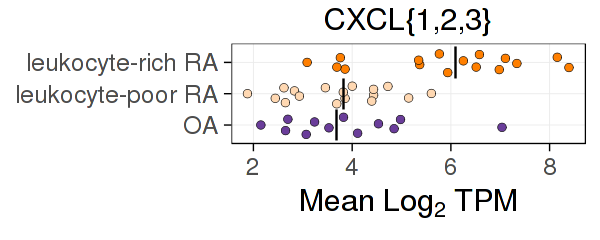

In [95]:
options(repr.plot.width = 5, repr.plot.height = 2)

# cxcl_ens <- names(ens83_to_symbol)[which(ens83_to_symbol %in% c("CXCL1", "CXCL2", "CXCL3", "CXCL6", "CXCL8"))]
cxcl_ens <- names(ens83_to_symbol)[which(ens83_to_symbol %in% c("CXCL1", "CXCL2", "CXCL3"))]

# bulk_meta_fib$mygene <- (colSums(2 ^ bulk_fib[il17_genes, ] - 1) + 1) / 1e6 * 100
# bulk_meta_fib$mygene <- (colSums(2 ^ bulk_fib[cxcl_ens, ] - 1) + 1) / 1e6 * 100
bulk_meta_fib$mygene <- colMeans(bulk_fib[cxcl_ens,])

bulk_meta_fib$status <- factor(as.character(bulk_meta_fib$status), c("OA", "leukocyte-poor RA", "leukocyte-rich RA"))

bulk_meta_fib_median <- bulk_meta_fib %>%
group_by(status) %>%
summarise(median = median(mygene)) %>%
mutate(x = as.integer(status))

ggplot(bulk_meta_fib) +
aes(x = status, y = mygene, fill = status) +
# scale_y_sqrt(breaks = scales::pretty_breaks(7)) +
geom_quasirandom(shape = 21, size = 2, stroke = 0.2) +
geom_segment(
  data = bulk_meta_fib_median,
  mapping = aes(x = x - 0.5, xend = x + 0.5, y = median, yend = median),
  size = 0.5
) +
scale_fill_manual(values = meta_colors$status, name = NULL, guide = FALSE) +
coord_flip() +
labs(x = NULL, y = bquote("Mean Log"[2]~"TPM"), title = "CXCL{1,2,3}")

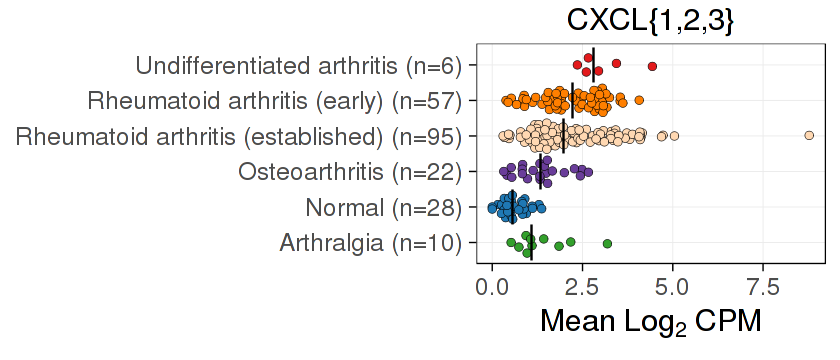

In [96]:
options(repr.plot.width = 7, repr.plot.height = 3)

# cxcl_genes <- c("CXCL1", "CXCL2", "CXCL3", "CXCL6", "CXCL8")
cxcl_genes <- c("CXCL1", "CXCL2", "CXCL3")

walsh_meta$mygene <- colMeans(walsh[cxcl_genes,])
walsh_meta$diseasen <- factor(as.character(walsh_meta$diseasen), names(meta_colors$diseasen))

walsh_median <- walsh_meta %>%
group_by(diseasen) %>%
summarise(median = median(mygene)) %>%
mutate(x = as.integer(diseasen))

ggplot(walsh_meta) +
aes(x = diseasen, y = mygene, fill = diseasen) +
# scale_y_sqrt(breaks = scales::pretty_breaks(7)) +
geom_quasirandom(shape = 21, size = 2, stroke = 0.2) +
geom_segment(
  data = walsh_median,
  mapping = aes(x = x - 0.5, xend = x + 0.5, y = median, yend = median),
  size = 0.5
) +
scale_fill_manual(values = meta_colors$diseasen, name = NULL, guide = FALSE) +
coord_flip() +
labs(x = NULL, y = bquote("Mean Log"[2]~"CPM"), title = "CXCL{1,2,3}")

In [97]:
head(walsh_meta)

geo_accession sex age disease acpa type    percent_common
normal_tissue_1 GSM2370970    M   13  Normal  NA   healthy 99.83487      
normal_tissue_2 GSM2370971    F   32  Normal  NA   healthy 99.52296      
normal_tissue_3 GSM2370972    M   22  Normal  NA   healthy 99.96942      
normal_tissue_4 GSM2370973    M   47  Normal  NA   healthy 99.95107      
normal_tissue_5 GSM2370974    M   27  Normal  NA   healthy 99.92049      
normal_tissue_6 GSM2370975    M   47  Normal  NA   healthy 99.98165      
                diseasen      mygene   
normal_tissue_1 Normal (n=28) 0.9421459
normal_tissue_2 Normal (n=28) 0.1575510
normal_tissue_3 Normal (n=28) 0.3710576
normal_tissue_4 Normal (n=28) 0.9009969
normal_tissue_5 Normal (n=28) 0.2603650
normal_tissue_6 Normal (n=28) 1.2951980

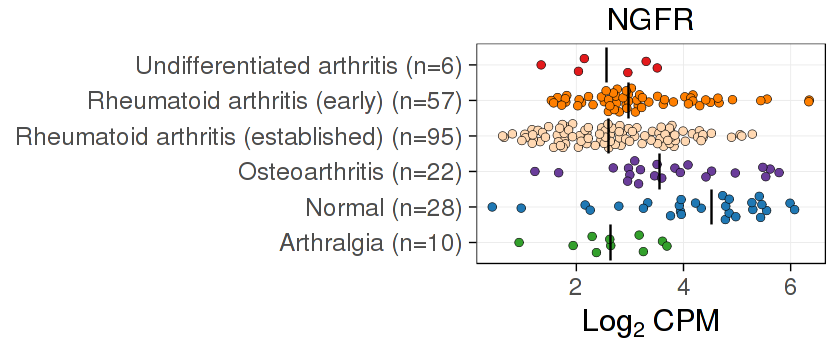

In [98]:
options(repr.plot.width = 7, repr.plot.height = 3)

# cxcl_genes <- c("CXCL1", "CXCL2", "CXCL3", "CXCL6", "CXCL8")
cxcl_genes <- c("NGFR")

walsh_meta$mygene <- as.numeric(walsh[cxcl_genes,])
walsh_meta$diseasen <- factor(as.character(walsh_meta$diseasen), names(meta_colors$diseasen))

walsh_median <- walsh_meta %>%
group_by(diseasen) %>%
summarise(median = median(mygene)) %>%
mutate(x = as.integer(diseasen))

ggplot(walsh_meta) +
aes(x = diseasen, y = mygene, fill = diseasen) +
# scale_y_sqrt(breaks = scales::pretty_breaks(7)) +
geom_quasirandom(shape = 21, size = 2, stroke = 0.2) +
geom_segment(
  data = walsh_median,
  mapping = aes(x = x - 0.5, xend = x + 0.5, y = median, yend = median),
  size = 0.5
) +
scale_fill_manual(values = meta_colors$diseasen, name = NULL, guide = FALSE) +
coord_flip() +
labs(x = NULL, y = bquote("Log"[2]~"CPM"), title = "NGFR")

# Walsh limma

In [99]:
clean_cols <- function(x) {
  colnames(x) <- str_replace_all(colnames(x), "[()]", "")
  colnames(x) <- str_replace_all(colnames(x), ":", "")
  colnames(x) <- str_replace_all(colnames(x), "status2", "")
  colnames(x) <- str_replace_all(colnames(x), "disease", "")
  colnames(x) <- str_replace_all(colnames(x), " ", "_")
  return(x)
}

walsh_des1 <- clean_cols(with(
  walsh_meta,
  model.matrix(~ 0 + disease)
))
walsh_fit1 <- lmFit(object = walsh, design = walsh_des1)
walsh_fit1 <- eBayes(walsh_fit1)

print(colnames(walsh_des1))

walsh_fit1_top <- rbindlist(lapply(colnames(walsh_des1), function(this_coef) {
  retval <- topTable(walsh_fit1, coef = this_coef, confint = TRUE, number = 1e6)
  retval$ID <- rownames(retval)
  retval$Coef <- this_coef
  retval
}))

head(walsh_fit1_top)

walsh_con1 <- limma::contrasts.fit(
  fit = walsh_fit1,
  contrasts = makeContrasts(
    contrasts = c(
      "Rheumatoid_arthritis_early - Normal"
    ),
    levels = walsh_des1
  )
)
walsh_con1 <- eBayes(walsh_con1)

walsh_con1_top <- topTable(walsh_con1, coef = 1, confint = TRUE, number = 1e6)
walsh_con1_top <- cbind(ID = rownames(walsh_con1_top), walsh_con1_top, stringsAsFactors = FALSE)
rownames(walsh_con1_top) <- seq(nrow(walsh_con1_top))

head(walsh_con1_top)

walsh_con1_top %>% filter(ID == "IL6")

[1] "Arthralgia"                       "Normal"                          
[3] "Osteoarthritis"                   "Rheumatoid_arthritis_early"      
[5] "Rheumatoid_arthritis_established" "Undifferentiated_arthritis"      


logFC     CI.L      CI.R      AveExpr   t        P.Value       adj.P.Val    
1 17.101126 16.637950 17.564301 17.132940 72.77788 1.515737e-152 3.796769e-148
2  9.965058  9.639913 10.290202  9.056888 60.41208 4.234676e-136 5.303720e-132
3  8.963048  8.666145  9.259951  8.076025 59.50607 8.873007e-135 7.408665e-131
4  7.767996  7.506516  8.029476  7.265267 58.55867 2.233124e-133 1.398438e-129
5  9.551019  9.227744  9.874295  8.863530 58.23670 6.753795e-133 3.383516e-129
6  9.500082  9.177553  9.822611  8.833069 58.06021 1.241670e-132 5.183765e-129
  B        ID          Coef      
1 338.3917 Metazoa_SRP Arthralgia
2 300.8593 RPL13A      Arthralgia
3 297.8370 HNRNPA1     Arthralgia
4 294.6316 RPS9        Arthralgia
5 293.5316 RPL3        Arthralgia
6 292.9263 EEF1G       Arthralgia

ID     logFC    CI.L     CI.R     AveExpr  t        P.Value      adj.P.Val   
1 ABCC4  2.290486 1.969719 2.611253 4.266196 14.07531 2.955594e-32 7.403468e-28
2 S100A9 4.677269 4.007647 5.346890 5.519135 13.76840 2.802820e-31 3.510392e-27
3 BRCA2  2.773723 2.362059 3.185387 4.156710 13.28129 9.902311e-30 8.268100e-26
4 SRGN   3.780062 3.208929 4.351195 6.430034 13.04613 5.515365e-29 3.453859e-25
5 EVI2A  3.156508 2.677767 3.635248 4.807287 12.99652 7.920516e-29 3.968020e-25
6 UBE2J1 2.200225 1.851122 2.549329 6.066860 12.42320 5.128744e-27 2.141165e-23
  B       
1 62.54153
2 60.33076
3 56.82691
4 55.13870
5 54.78291
6 50.68278

ID  logFC   CI.L      CI.R     AveExpr  t        P.Value      adj.P.Val   
1 IL6 1.53147 0.8902507 2.172689 1.484431 4.707844 4.505127e-06 1.263281e-05
  B       
1 3.537589

In [100]:
walsh_con1_top %>%
filter(ID %in% ens83_to_symbol[cats$C1])

ID       logFC       CI.L        CI.R        AveExpr    t         
1  GPR183    3.02202810  2.53313112  3.51092508 4.23358218 12.1843217
2  NAMPT     2.89574191  2.33462309  3.45686074 6.96176731 10.1724420
3  STEAP1    2.07954377  1.57561795  2.58346959 3.55188128  8.1343277
4  PIM2      3.16855379  2.39312760  3.94397999 3.52511063  8.0545416
5  STAT4     1.51356882  1.11425513  1.91288251 2.78873957  7.4715066
6  PLD1      1.35149933  0.92778754  1.77521113 5.39038384  6.2873190
7  STC1      1.27358145  0.72464392  1.82251898 2.01759207  4.5732402
8  POU2F2    0.86821297  0.46689752  1.26952842 3.41270189  4.2644262
9  HMGN2P46  0.59116898  0.28136200  0.90097595 0.82743196  3.7613232
10 LYPD3     0.53129435  0.24626574  0.81632296 0.71327960  3.6742352
11 IL23A     0.27396524  0.12291980  0.42501068 0.31819537  3.5752635
12 RERG      0.84633232  0.32586193  1.36680271 5.26056148  3.2052736
13 HAS1     -0.93694075 -1.57665090 -0.29723059 3.40154535 -2.8870153
14 SEMA6D    0.69254376  0.13439837  1.25068915 4.90307961  2.4457952
15 RASD1    -0.68683163 -1.26533099 -0.10833228 2.48103137 -2.3402789
16 NR4A2     0.57247520  0.06527736  1.07967305 2.40629246  2.2248436
17 NR4A1    -0.57770802 -1.12520881 -0.03020722 3.31914524 -2.0799067
18 TNFSF9    0.19071938 -0.04749625  0.42893502 1.26607760  1.5781373
19 ELF3     -0.11013666 -0.30390418  0.08363085 0.85957118 -1.1203950
20 IL11      0.10993033 -0.14136485  0.36122552 0.17058710  0.8622905
21 PID1      0.07872876 -0.27052644  0.42798396 3.79654387  0.4443352
22 CSF3     -0.04282621 -0.29749161  0.21183919 0.12295619 -0.3314820
23 SERPINA9  0.01412671 -0.09770869  0.12596212 0.07321365  0.2489901
   P.Value      adj.P.Val    B         
1  2.892512e-26 7.245454e-23 48.9821038
2  4.553700e-20 2.993849e-18 34.9577936
3  3.386892e-14 3.071625e-13 21.6977562
4  5.591175e-14 4.832758e-13 21.2071867
5  2.014315e-12 1.307504e-11 17.7030676
6  1.798868e-09 7.611461e-09 11.0846177
7  8.139132e-06 2.214130e-05  2.9731845
8  3.011304e-05 7.623993e-05  1.7295196
9  2.183661e-04 4.949198e-04 -0.1378834
10 3.017751e-04 6.703171e-04 -0.4404752
11 4.327806e-04 9.385906e-04 -0.7767734
12 1.556482e-03 3.113337e-03 -1.9611737
13 4.289565e-03 8.007848e-03 -2.8857913
14 1.526388e-02 2.596393e-02 -4.0188756
15 2.019331e-02 3.358714e-02 -4.2636674
16 2.713963e-02 4.400988e-02 -4.5197164
17 3.872943e-02 6.105308e-02 -4.8236756
18 1.160165e-01 1.635303e-01 -5.7230163
19 2.638059e-01 3.361582e-01 -6.3326029
20 3.894965e-01 4.686813e-01 -6.5861847
21 6.572509e-01 7.199667e-01 -6.8574743
22 7.406060e-01 7.922895e-01 -6.9010331
23 8.036082e-01 8.447868e-01 -6.9248636

category n   iwa     
1 C1        23 1.249292
2 C2        25 1.659489
3 C3       353 1.228723
4 C4        13 2.930251
5 C5       178 1.231793

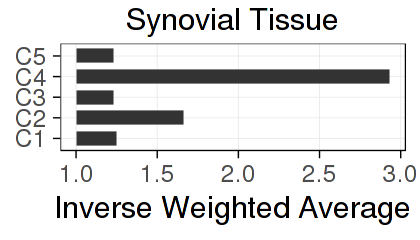

In [103]:
d <- bind_rows(lapply(c("C1", "C2", "C3", "C4", "C5"), function(this_cat) {
  these_genes <- intersect(ens83_to_symbol[cats[[this_cat]]], rownames(walsh_con1$coefficients))
  mu <- walsh_con1$coefficients[these_genes,1]
  s2 <- walsh_con1$s2.post[these_genes]
  list(category = this_cat, n = length(these_genes), iwa = 2 ^ (sum(mu / s2) / sum(1 / s2)))
}))

d

options(repr.plot.width = 3.5, repr.plot.height = 2)

ggplot(d) +
geom_segment(aes(x = category, xend = category, y = iwa, yend = 1), size = 3, color = "grey20") +
coord_flip() +
labs(x = NULL, y = "Inverse Weighted Average", title = "Synovial Tissue")

In [104]:
head(walsh_meta)

geo_accession sex age disease acpa type    percent_common
normal_tissue_1 GSM2370970    M   13  Normal  NA   healthy 99.83487      
normal_tissue_2 GSM2370971    F   32  Normal  NA   healthy 99.52296      
normal_tissue_3 GSM2370972    M   22  Normal  NA   healthy 99.96942      
normal_tissue_4 GSM2370973    M   47  Normal  NA   healthy 99.95107      
normal_tissue_5 GSM2370974    M   27  Normal  NA   healthy 99.92049      
normal_tissue_6 GSM2370975    M   47  Normal  NA   healthy 99.98165      
                diseasen      mygene   
normal_tissue_1 Normal (n=28) 5.5512817
normal_tissue_2 Normal (n=28) 0.9701403
normal_tissue_3 Normal (n=28) 4.7808471
normal_tissue_4 Normal (n=28) 3.3324423
normal_tissue_5 Normal (n=28) 3.2517962
normal_tissue_6 Normal (n=28) 3.9438463

[1] "CXCL1"   "CXCL2"   "CXCL3"   "CCL8"    "IL6"     "NFKBIZ"  "ZC3H12A"
[8] "NR4A2"  


diseasen      geo_accession gene  value     
1 Normal (n=28) GSM2370970    CXCL1 1.56420173
2 Normal (n=28) GSM2370971    CXCL1 0.03042338
3 Normal (n=28) GSM2370972    CXCL1 0.53004112
4 Normal (n=28) GSM2370973    CXCL1 1.24363928
5 Normal (n=28) GSM2370974    CXCL1 0.04194387
6 Normal (n=28) GSM2370975    CXCL1 1.42573571

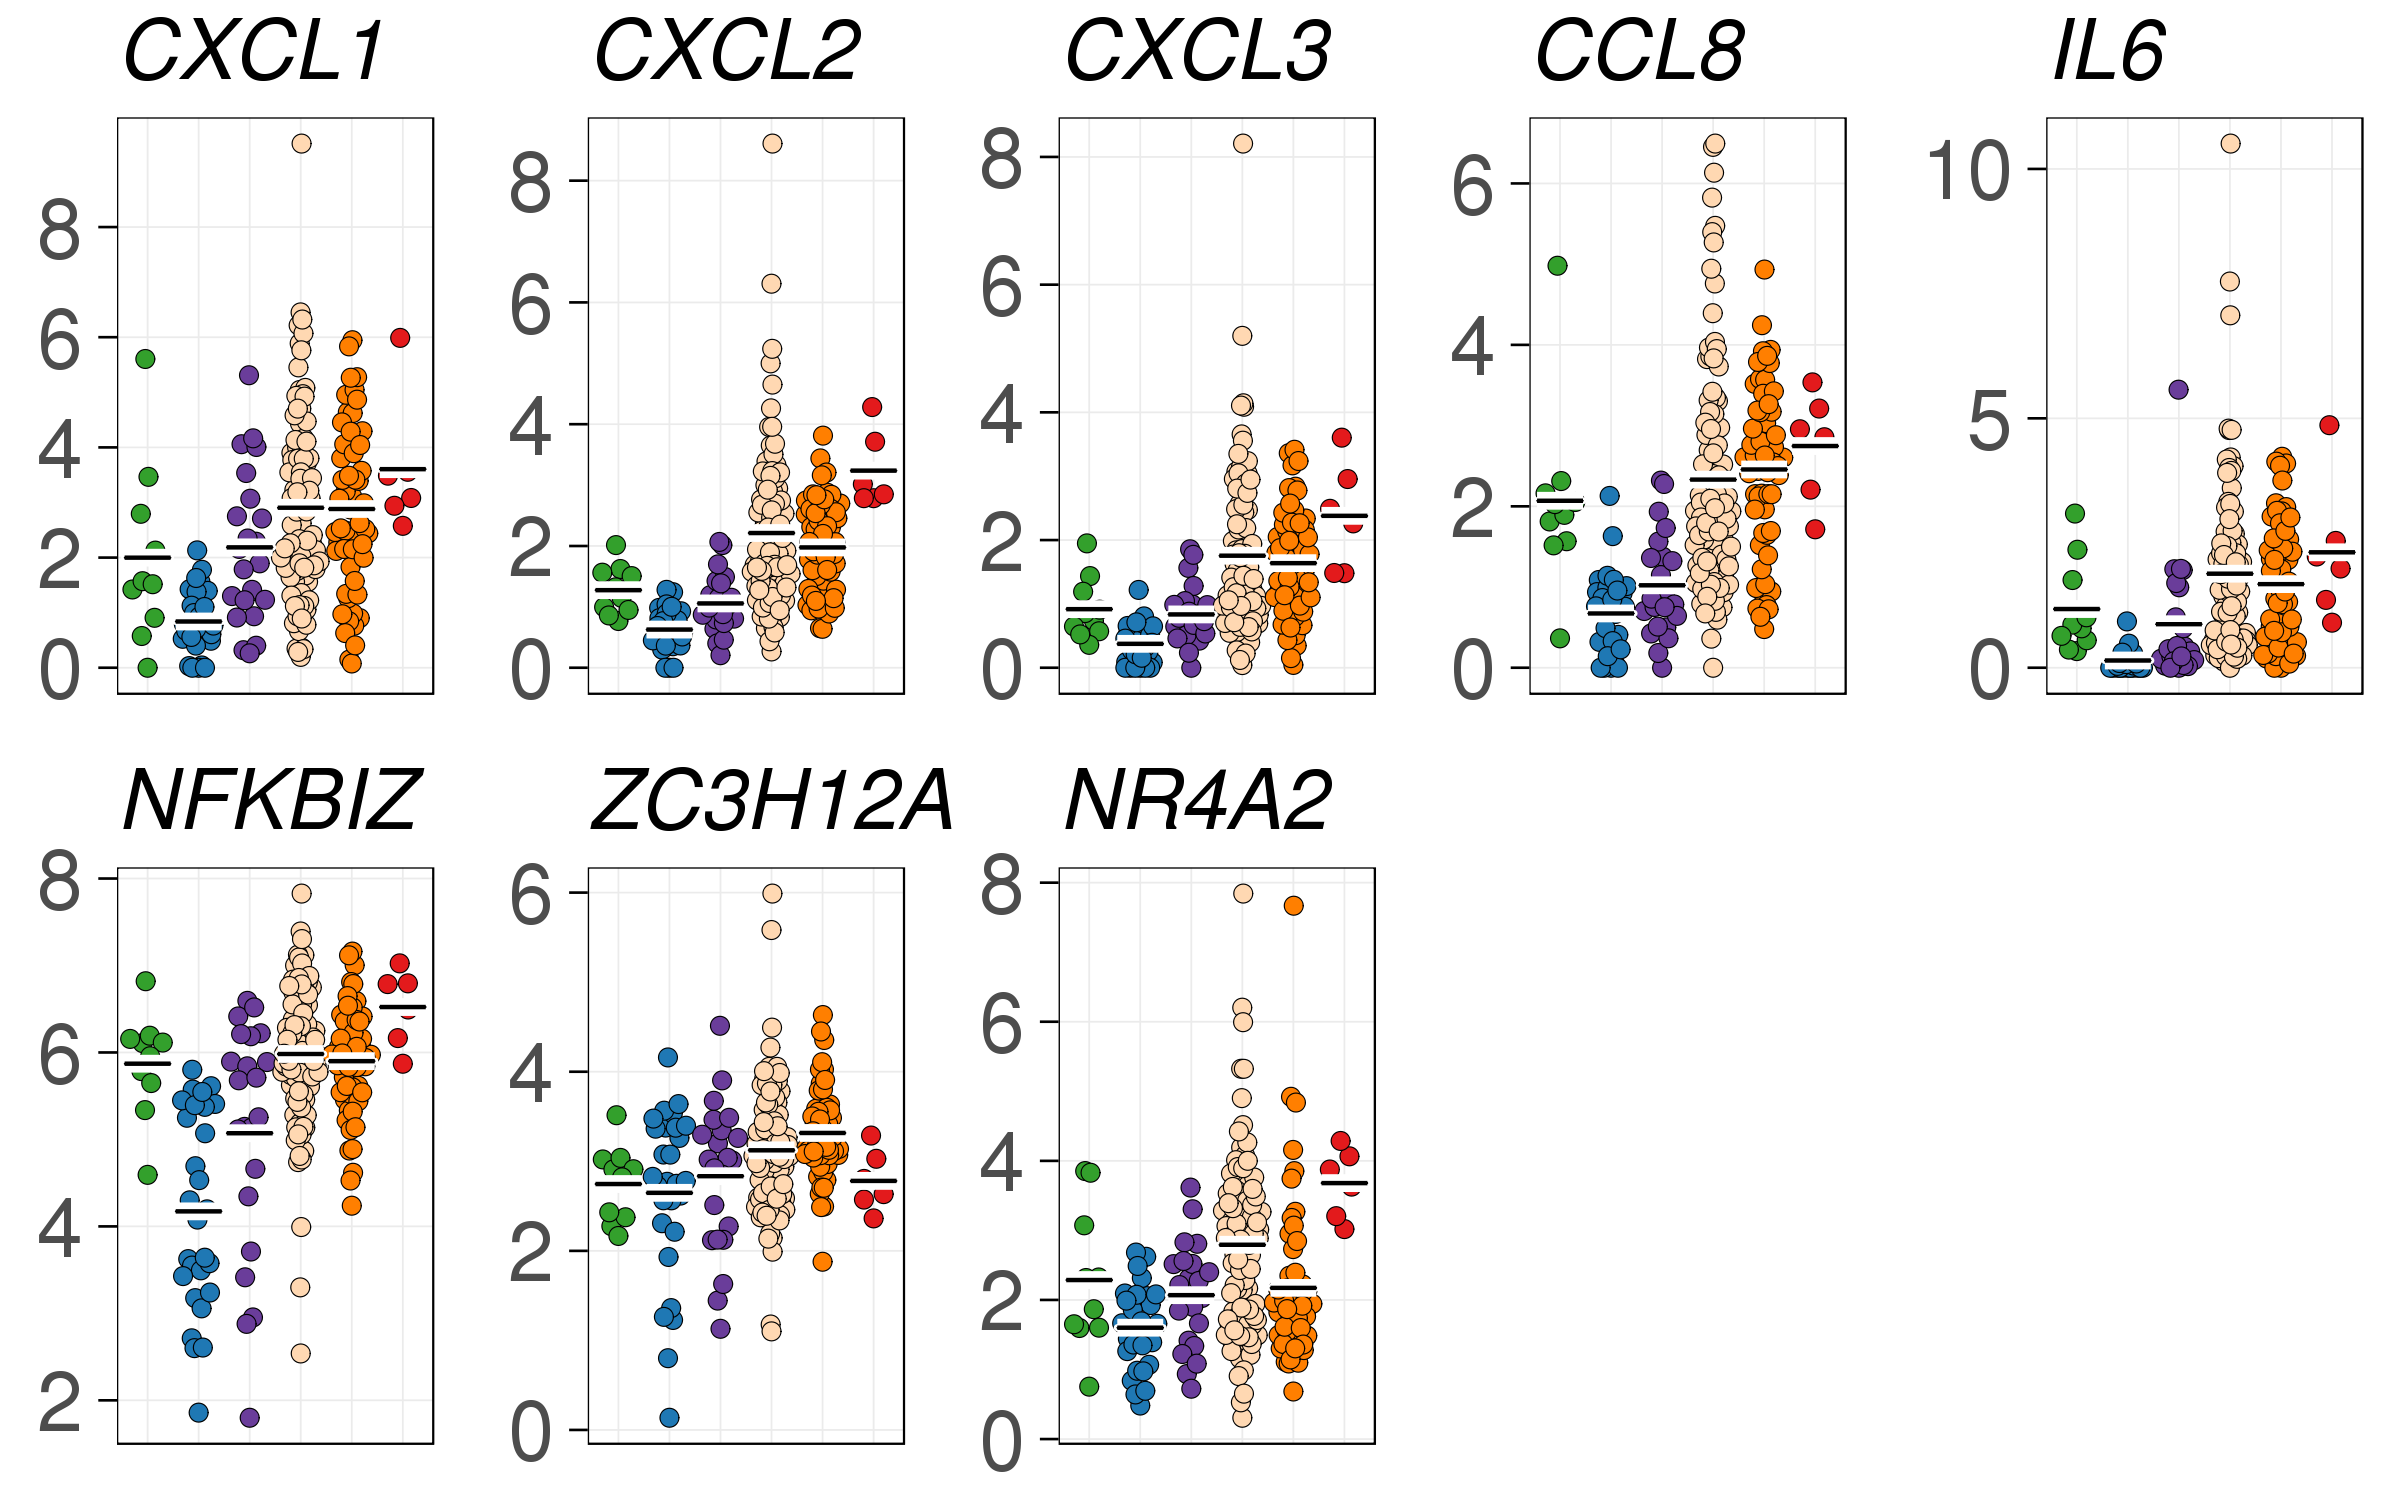

In [105]:
options(repr.plot.width = 8, repr.plot.height = 5)

# this_gene <- c(
#   "LYPD3", "NR4A2", "RERG",
#   "CXCL2", "NFKBIZ", "CCL8", "ZC3H12A", "PTGS2", "MT1G", "IER3", "IL6", "SLC7A2", "CXCL1", "CXCL3"
# )
this_gene <- c(
  "CXCL1", "CXCL2", "CXCL3", "CCL8", "IL6",
  "NFKBIZ", "ZC3H12A", "NR4A2"
)
# this_gene <- intersect(rownames(walsh), this_gene)
print(this_gene)

d <- cbind(
  walsh_meta[,c("diseasen", "geo_accession")],
  t(walsh[this_gene,])
)

d <- d %>% tidyr::gather("gene", "value", -diseasen, -geo_accession)

head(d)

plots <- lapply(this_gene, function(i) {  
  ggplot(d %>% filter(gene == i)) +
  aes(x = diseasen, y = value, fill = diseasen) +
  geom_quasirandom(shape = 21, size = 2, stroke = 0.2) +
  stat_summary(fun.y = mean, fun.ymin = mean, fun.ymax = mean, geom = "crossbar", width = 0.9, size = 0.8, color = "white") +
  stat_summary(fun.y = mean, fun.ymin = mean, fun.ymax = mean, geom = "crossbar", width = 0.9, size = 0.2) +
  scale_fill_manual(values = meta_colors$diseasen, name = NULL, guide = FALSE) +
  scale_y_continuous(breaks = scales::pretty_breaks(4)) +
  labs(x = NULL, y = NULL, title = i) +
  theme(
    legend.position = "none",
    axis.text.x = element_blank(), axis.ticks.x = element_blank(), plot.title = element_text(size = 20, face = "italic", hjust = 0),
    axis.text.y = element_text(size = 20)
  )
})

# # plots[[11]] <- plots[[11]] + theme(legend.position = "right") + guides(fill = guide_legend(override.aes = aes(shape = NA, size = 0), reverse = TRUE, keyheight = 2))

show_plot(res = 300,
  wrap_plots(plots, ncol = 5)
)



 [1] "CXCL1"  "CXCL2"  "CXCL3"  "CXCL6"  "CXCL8"  "IL6"    "CCL2"   "CCL8"  
 [9] "NFKBIZ" "PTGS2" 


diseasen      geo_accession gene  value     
1 Normal (n=28) GSM2370970    CXCL1 1.56420173
2 Normal (n=28) GSM2370971    CXCL1 0.03042338
3 Normal (n=28) GSM2370972    CXCL1 0.53004112
4 Normal (n=28) GSM2370973    CXCL1 1.24363928
5 Normal (n=28) GSM2370974    CXCL1 0.04194387
6 Normal (n=28) GSM2370975    CXCL1 1.42573571

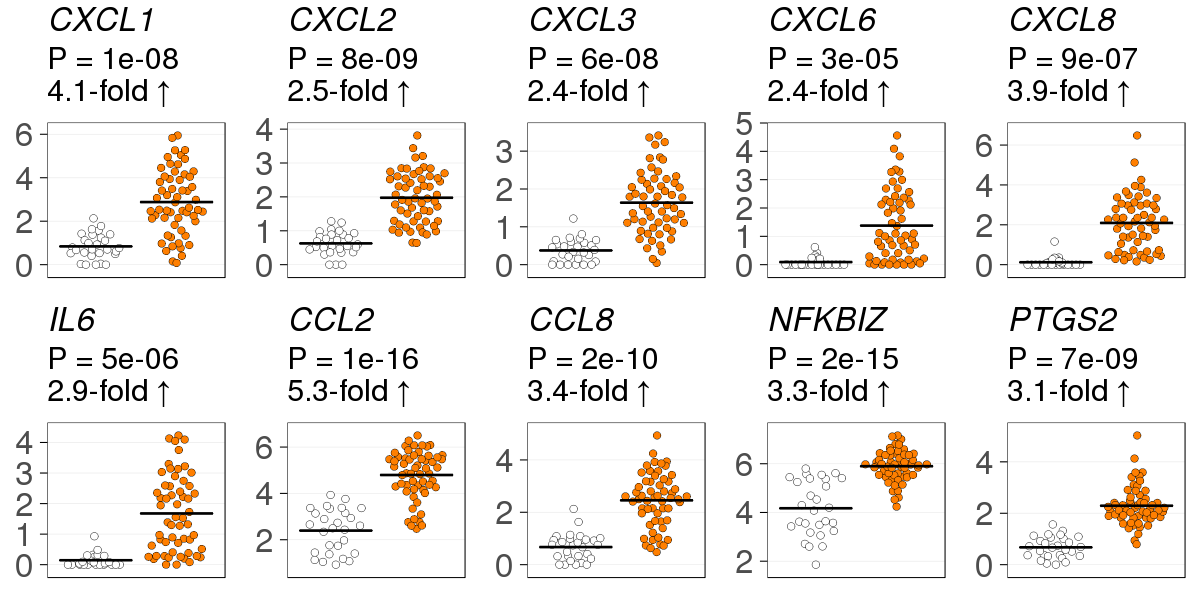

In [126]:
options(repr.plot.width = 10, repr.plot.height = 5)

# this_gene <- c(
#   "LYPD3", "NR4A2", "RERG",
#   "CXCL2", "NFKBIZ", "CCL8", "ZC3H12A", "PTGS2", "MT1G", "IER3", "IL6", "SLC7A2", "CXCL1", "CXCL3"
# )
this_gene <- c(
  "CXCL1", "CXCL2", "CXCL3","CXCL6", "CXCL8",
  "IL6", "CCL2", "CCL8", "NFKBIZ", "PTGS2" # "ZC3H12A", "NR4A2"
)
# this_gene <- intersect(rownames(walsh), this_gene)
print(this_gene)

d <- cbind(
  walsh_meta[,c("diseasen", "geo_accession")],
  t(walsh[this_gene,])
)

d %<>% filter(diseasen %in% c("Normal (n=28)", "Rheumatoid arthritis (early) (n=57)"))

d <- d %>% tidyr::gather("gene", "value", -diseasen, -geo_accession)

head(d)

plot_walsh_gene <- function(i) {
  pval <- sprintf("P = %s", signif((walsh_con1_top %>% filter(ID == i))$P.Value, 1))
  fc   <- sprintf("%s-fold ↑", signif(2 ^ (walsh_con1_top %>% filter(ID == i))$logFC, 2))
  ymax <- max((d %>% filter(gene == i))$value)
  ymin <- min((d %>% filter(gene == i))$value)
  ggplot(d %>% filter(gene == i)) +
  aes(x = diseasen, y = value, fill = diseasen) +
  geom_quasirandom(shape = 21, size = 2, stroke = 0.2) +
#   annotate(geom = "text", x = 1.5, y = ymax + 2, label = pval, hjust = 0.5, size = 7) +
#   annotate(geom = "text", x = 1.5, y = ymin - 1.5, label = fc, hjust = 0.5, size = 7) +
#   stat_summary(fun.y = mean, fun.ymin = mean, fun.ymax = mean, geom = "crossbar", width = 0.9, size = 0.8, color = "white") +
  stat_summary(fun.y = mean, fun.ymin = mean, fun.ymax = mean, geom = "crossbar", width = 0.9, size = 0.3) +
  scale_fill_manual(
    values = c(
      "Normal (n=28)" = "white",
      "Rheumatoid arthritis (early) (n=57)" = RColorBrewer::brewer.pal(9, "Paired")[8] #"grey20"
    ),
    name = NULL,
    guide = FALSE
  ) +
  scale_y_continuous(breaks = scales::pretty_breaks(4), expand = c(0.1, 0)) +
  # labs(x = NULL, y = NULL, title = i) +
  labs(x = NULL, y = NULL, title = i, subtitle = sprintf("%s\n%s", pval, fc)) +
  theme(panel.grid.major.x = element_blank(),
    legend.position = "none",
    axis.text.x = element_blank(), axis.ticks.x = element_blank(), plot.title = element_text(size = 20, face = "italic", hjust = 0),
    axis.text.y = element_text(size = 20)
  )
}

plots <- lapply(this_gene, plot_walsh_gene)

# # plots[[11]] <- plots[[11]] + theme(legend.position = "right") + guides(fill = guide_legend(override.aes = aes(shape = NA, size = 0), reverse = TRUE, keyheight = 2))

show_plot(name = "figure5-guo",
  wrap_plots(plots, ncol = 5)
)



 [1] "CXCL1"  "CXCL2"  "CXCL3"  "CXCL6"  "CXCL8"  "IL6"    "CCL2"   "CCL8"  
 [9] "NFKBIZ" "PTGS2"  "IL17A"  "IL17D"  "TNF"   


diseasen                            geo_accession has_il17 gene  value    
1 Rheumatoid arthritis (early) (n=57) GSM2371036    FALSE    CXCL1 0.1485179
2 Rheumatoid arthritis (early) (n=57) GSM2371037    FALSE    CXCL1 2.4111481
3 Rheumatoid arthritis (early) (n=57) GSM2371038    FALSE    CXCL1 2.2761810
4 Rheumatoid arthritis (early) (n=57) GSM2371039     TRUE    CXCL1 2.8710948
5 Rheumatoid arthritis (early) (n=57) GSM2371040    FALSE    CXCL1 0.9014323
6 Rheumatoid arthritis (early) (n=57) GSM2371041    FALSE    CXCL1 5.9456605

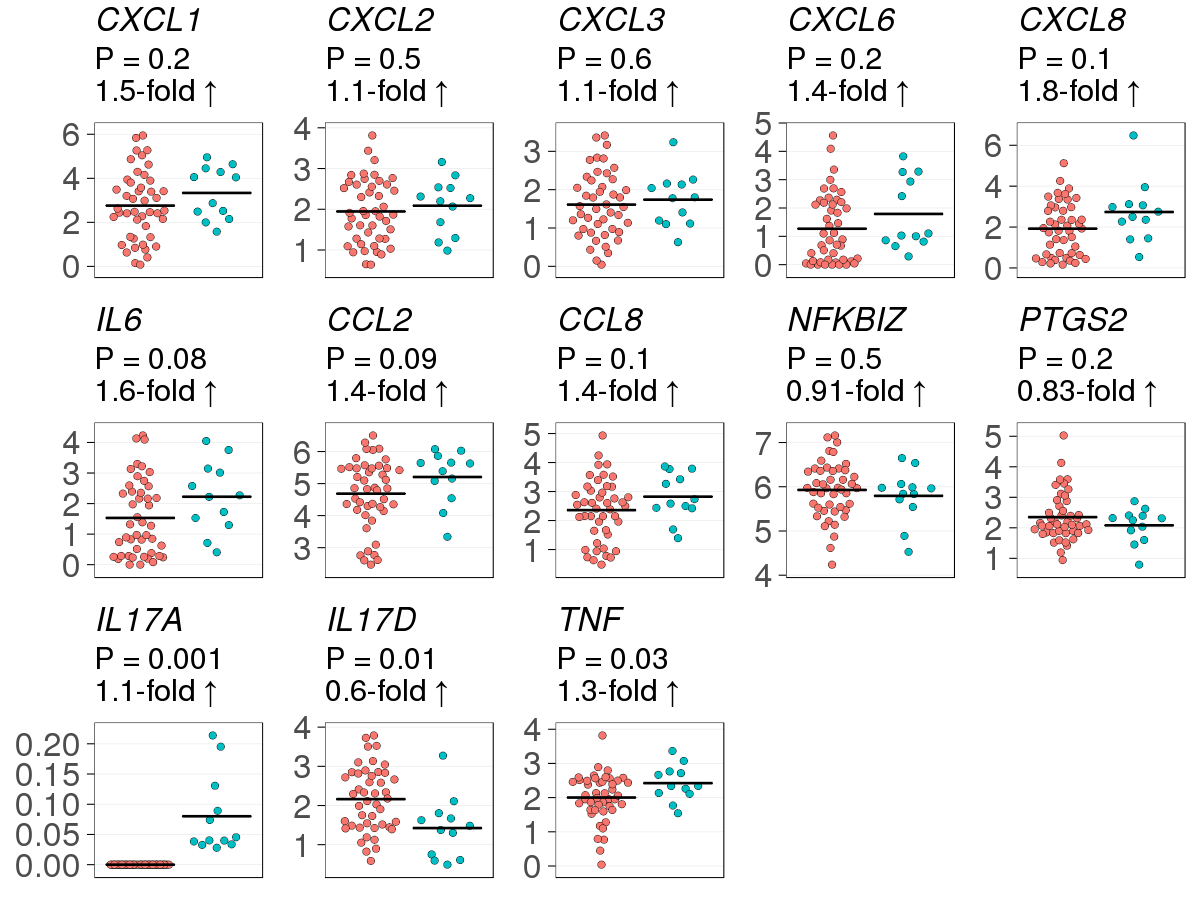

In [166]:
options(repr.plot.width = 10, repr.plot.height = 7.5)

# this_gene <- c(
#   "LYPD3", "NR4A2", "RERG",
#   "CXCL2", "NFKBIZ", "CCL8", "ZC3H12A", "PTGS2", "MT1G", "IER3", "IL6", "SLC7A2", "CXCL1", "CXCL3"
# )
this_gene <- c(
  "CXCL1", "CXCL2", "CXCL3","CXCL6", "CXCL8",
  "IL6", "CCL2", "CCL8", "NFKBIZ", "PTGS2", "IL17A", "IL17D", "TNF" # "ZC3H12A", "NR4A2"
)
# this_gene <- intersect(rownames(walsh), this_gene)
print(this_gene)

d <- cbind(
  walsh_meta[,c("diseasen", "geo_accession")],
  t(walsh[this_gene,])
)

d %<>% filter(diseasen %in% c("Rheumatoid arthritis (early) (n=57)"))

d$has_il17 <- d$IL17A > 0

d <- d %>% tidyr::gather("gene", "value", -diseasen, -geo_accession, -has_il17)

head(d)


plot_walsh_gene <- function(i) {
  res <- with(subset(d, gene == i), t.test(value ~ has_il17))
  pval <- sprintf("P = %s", signif(res$p.value, 1))
  fc   <- sprintf("%s-fold ↑", signif(2 ^ -Reduce("-", res$estimate), 2))
  ymax <- max((d %>% filter(gene == i))$value)
  ymin <- min((d %>% filter(gene == i))$value)
  ggplot(d %>% filter(gene == i)) +
  aes(x = has_il17, y = value, fill = has_il17) +
  geom_quasirandom(shape = 21, size = 2, stroke = 0.2) +
#   annotate(geom = "text", x = 1.5, y = ymax + 2, label = pval, hjust = 0.5, size = 7) +
#   annotate(geom = "text", x = 1.5, y = ymin - 1.5, label = fc, hjust = 0.5, size = 7) +
#   stat_summary(fun.y = mean, fun.ymin = mean, fun.ymax = mean, geom = "crossbar", width = 0.9, size = 0.8, color = "white") +
  stat_summary(fun.y = mean, fun.ymin = mean, fun.ymax = mean, geom = "crossbar", width = 0.9, size = 0.3) +
#   scale_fill_manual(
#     values = c(
#       "Normal (n=28)" = "white",
#       "Rheumatoid arthritis (early) (n=57)" = RColorBrewer::brewer.pal(9, "Paired")[8] #"grey20"
#     ),
#     name = NULL,
#     guide = FALSE
#   ) +
  scale_y_continuous(breaks = scales::pretty_breaks(4), expand = c(0.1, 0)) +
  # labs(x = NULL, y = NULL, title = i) +
  labs(x = NULL, y = NULL, title = i, subtitle = sprintf("%s\n%s", pval, fc)) +
  theme(panel.grid.major.x = element_blank(),
    legend.position = "none",
    axis.text.x = element_blank(), axis.ticks.x = element_blank(), plot.title = element_text(size = 20, face = "italic", hjust = 0),
    axis.text.y = element_text(size = 20)
  )
}

plots <- lapply(this_gene, plot_walsh_gene)

# # plots[[11]] <- plots[[11]] + theme(legend.position = "right") + guides(fill = guide_legend(override.aes = aes(shape = NA, size = 0), reverse = TRUE, keyheight = 2))

show_plot(name = "figure5-guo-response",
  wrap_plots(plots, ncol = 5)
)

